# Machine Learning Engineer Nanodegree
## Capstone Project: Predicting Credit Default with MLP
<p><b>David Petersen, May, 2018 </b>

### Table of Contents:

[I. Loading Datasets](#loading_datasets) <br />
[II. Exploratory Data Analysis](#eda) <br />
[III. Visualizing Features and Their Ability to Predict Default](#visualize)  <br />
[IV. Model Preparation - Data Preprocessing](#modelprep)  <br />
[V. Model Estimation - First Round](#estimation1) <br />
[VI. Engineering New Features for a Second Round of Models](#feature_engineering) <br />
[VII. Model Estimation - Round II - Taiwan Data](#estimation2) <br />
[VIII. MLP Model - Taiwan](#mlp-taiwan) <br />
[IX. RNN - Sequence Model](#rnn-taiwan) <br />
[X. Final Accuracy Statistics](#conclusions) <br />

<a id='loading_datasets'></a>
## I. Loading Datasets

In [123]:
# import and data handling libraries
import csv
import numpy as np
import pandas as pd

In [124]:
def getdata(dataset, filename):
    df = pd.read_csv(filename)
    print(dataset+' dataframe shape: '+str(df.shape))
    return df

In [125]:
taiwan = getdata('taiwan', '/Users/David/Dropbox/Capstone-Petersen/Data/credit_defaults.csv')
german = getdata('german', '/Users/David/Dropbox/Capstone-Petersen/Data/german_credit_data.csv')
aus = getdata('aus', '/Users/David/Dropbox/Capstone-Petersen/Data/australian_credit_data.csv')

taiwan dataframe shape: (30000, 25)
german dataframe shape: (1000, 21)
aus dataframe shape: (690, 15)


In [126]:
# Display a few observations from each dataset
from IPython.display import display

display('Taiwan',taiwan.head(5))
display('German',german.head(5))
display('Australian',aus.head(5))

'Taiwan'

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

      ...       BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     ...               0          0          0         0       689         0   
1     ...            3272       3455       3261         0      1000      1000   
2     ...           14331      14948      15549      1518      1500      1000   
3     ...           28314      28959      29547      2000      2019      1200   
4     ...           20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  Default_Pmt  
0         0         0         0            1  
1      1000         0      2000            1  
2      1000      1000      5000            0  
3      1100      1069      1000            0  
4      9000       689       679            0  

[5 rows x 25 columns]

'German'

Checking_Status  Duration Credit_History Loan_Purpose  Credit_Amount  \
0             A11         6            A34          A43           1169   
1             A12        48            A32          A43           5951   
2             A14        12            A34          A46           2096   
3             A11        42            A32          A42           7882   
4             A11        24            A33          A40           4870   

  Savings-Bonds Employment  Install_Rate Gender-Status Guarantor   ...    \
0           A65        A75             4           A93      A101   ...     
1           A61        A73             2           A92      A101   ...     
2           A61        A74             2           A93      A101   ...     
3           A61        A74             2           A93      A103   ...     
4           A61        A73             3           A93      A101   ...     

   Property Age_Yrs  Other_Inst Housing Bank_Credits   Job Dependents  \
0      A121      67        A143    A152            2  A173          1   
1      A121      22        A143    A152            1  A173          1   
2      A121      49        A143    A152            1  A172          2   
3      A122      45        A143    A153            1  A173          2   
4      A124      53        A143    A153            2  A173          2   

   Telephone Foreign_Worker Default  
0       A192           A201       1  
1       A191           A201       2  
2       A191           A201       1  
3       A191           A201       1  
4       A191           A201       2  

[5 rows x 21 columns]

'Australian'

Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
0         1     22.08     11.46         2         4         4      1.58   
1         0     22.67      7.00         2         8         4      0.17   
2         0     29.58      1.75         1         4         4      1.25   
3         0     21.67     11.50         1         5         3      0.00   
4         1     20.17      8.17         2         6         4      1.96   

   Feature8  Feature9  Feature10  Feature11  Feature12  Feature13  Feature14  \
0         0         0          0          1          2        100       1213   
1         0         0          0          0          2        160          1   
2         0         0          0          1          2        280          1   
3         1         1         11          1          2          0          1   
4         1         1         14          0          2         60        159   

   Default  
0        0  
1        0  
2        0  
3        1  
4        1

In [127]:
# drop ID from taiwan dataset - not needed for this analysis
del taiwan['ID']

In [128]:
# change the default variable from 1/2 to 0/1 and verify result
def fixy(df,labelvar):
    df[labelvar] = df[labelvar] - 1
    return df

fixy(german,'Default')
german['Default'].describe()

count   1000.00
mean       0.30
std        0.46
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        1.00
Name: Default, dtype: float64

<a id='eda'></a>
## II. Exploratory Data Analysis

### Tabulating classes 

In [129]:
# Create function to built single-var cross tabs for categorical variables
def count_maker(df):
    for colname, col in df.iteritems():
        display(pd.crosstab(index=df[colname],  # Make a crosstab
                      columns="count", margins=True))         # Name the count column


In [130]:
print('\n'+'German: Distribution of Non-Default (0) vs. Default (1): ')
count_maker(pd.DataFrame(german['Default']))

print('\n'+'Australian: Distribution of Non-Default (0) vs. Default (1): ')
count_maker(pd.DataFrame(aus['Default']))

print('\n'+'Taiwan: Distribution of Non-Default (0) vs. Default (1): ')
count_maker(pd.DataFrame(taiwan['Default_Pmt']))


German: Distribution of Non-Default (0) vs. Default (1): 


col_0    count   All
Default             
0          700   700
1          300   300
All       1000  1000


Australian: Distribution of Non-Default (0) vs. Default (1): 


col_0    count  All
Default            
0          383  383
1          307  307
All        690  690


Taiwan: Distribution of Non-Default (0) vs. Default (1): 


col_0        count    All
Default_Pmt              
0            23364  23364
1             6636   6636
All          30000  30000

### German Data Content Analysis

In [131]:
german.dtypes # ensure variables and features data types coded correctly

Checking_Status    object
Duration            int64
Credit_History     object
Loan_Purpose       object
Credit_Amount       int64
Savings-Bonds      object
Employment         object
Install_Rate        int64
Gender-Status      object
Guarantor          object
Res_Since           int64
Property           object
Age_Yrs             int64
Other_Inst         object
Housing            object
Bank_Credits        int64
Job                object
Dependents          int64
Telephone          object
Foreign_Worker     object
Default             int64
dtype: object

In [132]:
# Get simple frequency counts for German categorical variables
german_cat = german.select_dtypes(exclude=['int64']) # get the categorical variables from german dataset
count_maker(german_cat)

col_0            count   All
Checking_Status             
A11                274   274
A12                269   269
A13                 63    63
A14                394   394
All               1000  1000

col_0           count   All
Credit_History             
A30                40    40
A31                49    49
A32               530   530
A33                88    88
A34               293   293
All              1000  1000

col_0         count   All
Loan_Purpose             
A40             234   234
A41             103   103
A410             12    12
A42             181   181
A43             280   280
A44              12    12
A45              22    22
A46              50    50
A48               9     9
A49              97    97
All            1000  1000

col_0          count   All
Savings-Bonds             
A61              603   603
A62              103   103
A63               63    63
A64               48    48
A65              183   183
All             1000  1000

col_0       count   All
Employment             
A71            62    62
A72           172   172
A73           339   339
A74           174   174
A75           253   253
All          1000  1000

col_0          count   All
Gender-Status             
A91               50    50
A92              310   310
A93              548   548
A94               92    92
All             1000  1000

col_0      count   All
Guarantor             
A101         907   907
A102          41    41
A103          52    52
All         1000  1000

col_0     count   All
Property             
A121        282   282
A122        232   232
A123        332   332
A124        154   154
All        1000  1000

col_0       count   All
Other_Inst             
A141          139   139
A142           47    47
A143          814   814
All          1000  1000

col_0    count   All
Housing             
A151       179   179
A152       713   713
A153       108   108
All       1000  1000

col_0  count   All
Job               
A171      22    22
A172     200   200
A173     630   630
A174     148   148
All     1000  1000

col_0      count   All
Telephone             
A191         596   596
A192         404   404
All         1000  1000

col_0           count   All
Foreign_Worker             
A201              963   963
A202               37    37
All              1000  1000

In [133]:
pd.options.display.float_format = '{:.2f}'.format
german.select_dtypes(include=['int64']).describe()

Duration  Credit_Amount  Install_Rate  Res_Since  Age_Yrs  \
count   1000.00        1000.00       1000.00    1000.00  1000.00   
mean      20.90        3271.26          2.97       2.85    35.55   
std       12.06        2822.74          1.12       1.10    11.38   
min        4.00         250.00          1.00       1.00    19.00   
25%       12.00        1365.50          2.00       2.00    27.00   
50%       18.00        2319.50          3.00       3.00    33.00   
75%       24.00        3972.25          4.00       4.00    42.00   
max       72.00       18424.00          4.00       4.00    75.00   

       Bank_Credits  Dependents  Default  
count       1000.00     1000.00  1000.00  
mean           1.41        1.16     0.30  
std            0.58        0.36     0.46  
min            1.00        1.00     0.00  
25%            1.00        1.00     0.00  
50%            1.00        1.00     0.00  
75%            2.00        1.00     1.00  
max            4.00        2.00     1.00

/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


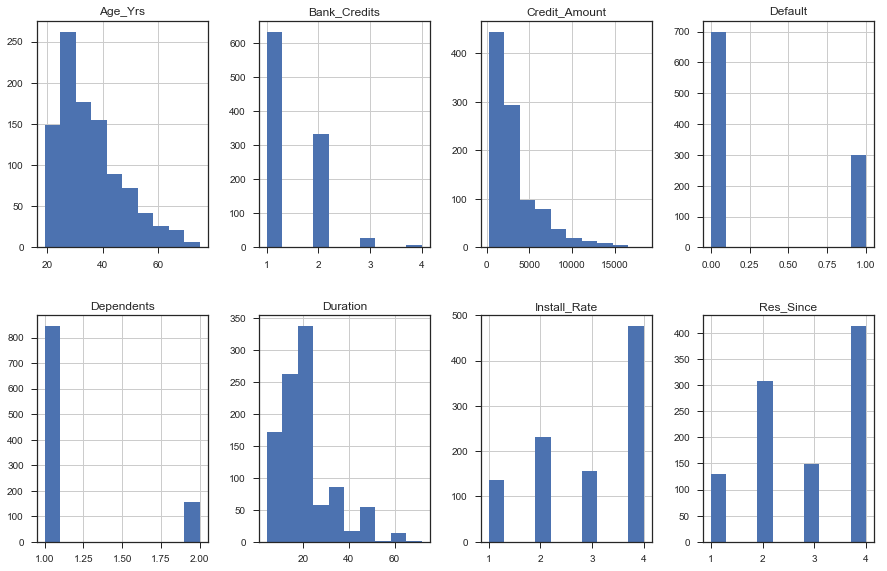

In [134]:
# Plot continuous variables to look for outliers
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
german.select_dtypes(exclude=['object']).hist(layout=(3,4), ax=ax)
plt.show()

### Australian Data Content Analysis

In [135]:
aus.dtypes # ensure variables and features data types coded correctly

Feature1       int64
Feature2     float64
Feature3     float64
Feature4       int64
Feature5       int64
Feature6       int64
Feature7     float64
Feature8       int64
Feature9       int64
Feature10      int64
Feature11      int64
Feature12      int64
Feature13      int64
Feature14      int64
Default        int64
dtype: object

In [136]:
# Columns we want to change to categorical features
objcol = ['Feature1','Feature4','Feature5', 'Feature6', 'Feature8', 'Feature9',
          'Feature11','Feature12','Feature15']

# Change them using 'astype'
def objmaker(df,collist):
    for colname, col in df.iteritems():
        if df[colname].name in collist:
            df[colname] = df[colname].astype(object)

objmaker(aus,objcol)

# Confirm changes         
aus.dtypes

Feature1      object
Feature2     float64
Feature3     float64
Feature4      object
Feature5      object
Feature6      object
Feature7     float64
Feature8      object
Feature9      object
Feature10      int64
Feature11     object
Feature12     object
Feature13      int64
Feature14      int64
Default        int64
dtype: object

In [137]:
# Get simple frequency counts for Australian categorical variables
aus_cat = aus.select_dtypes(include=['object']) # get the categorical variables from aus dataset
count_maker(aus_cat)

col_0     count  All
Feature1            
0           222  222
1           468  468
All         690  690

col_0     count  All
Feature4            
1           163  163
2           525  525
3             2    2
All         690  690

col_0     count  All
Feature5            
1            53   53
2            30   30
3            59   59
4            51   51
5            10   10
6            54   54
7            38   38
8           146  146
9            64   64
10           25   25
11           78   78
12            3    3
13           41   41
14           38   38
All         690  690

col_0     count  All
Feature6            
1            57   57
2             6    6
3             8    8
4           408  408
5            59   59
7             6    6
8           138  138
9             8    8
All         690  690

col_0     count  All
Feature8            
0           329  329
1           361  361
All         690  690

col_0     count  All
Feature9            
0           395  395
1           295  295
All         690  690

col_0      count  All
Feature11            
0            374  374
1            316  316
All          690  690

col_0      count  All
Feature12            
1             57   57
2            625  625
3              8    8
All          690  690

In [138]:
aus.select_dtypes(exclude=['object']).describe()

Feature2  Feature3  Feature7  Feature10  Feature13  Feature14  Default
count    690.00    690.00    690.00     690.00     690.00     690.00   690.00
mean      31.57      4.76      2.22       2.40     184.01    1018.39     0.44
std       11.85      4.98      3.35       4.86     172.16    5210.10     0.50
min       13.75      0.00      0.00       0.00       0.00       1.00     0.00
25%       22.67      1.00      0.17       0.00      80.00       1.00     0.00
50%       28.62      2.75      1.00       0.00     160.00       6.00     0.00
75%       37.71      7.21      2.62       3.00     272.00     396.50     1.00
max       80.25     28.00     28.50      67.00    2000.00  100001.00     1.00

/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


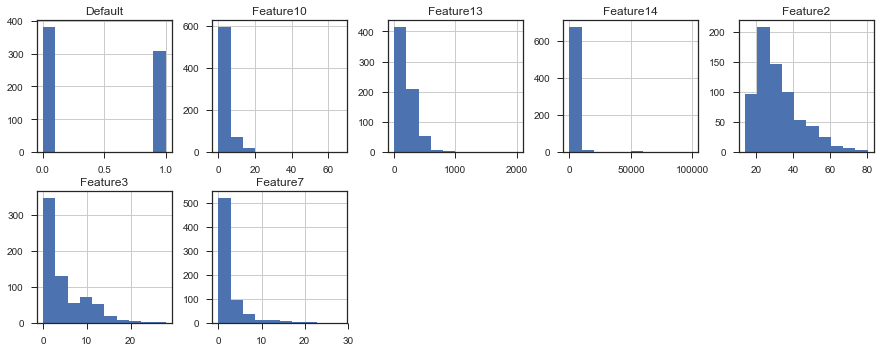

In [139]:
# Plot continuous variables to look for outliers
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
aus.select_dtypes(exclude=['object']).hist(layout=(5,5), ax=ax)
plt.show()


### Taiwan Data Content Analysis

In [140]:
taiwan.dtypes

LIMIT_BAL      int64
SEX            int64
EDUCATION      int64
MARRIAGE       int64
AGE            int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1      int64
BILL_AMT2      int64
BILL_AMT3      int64
BILL_AMT4      int64
BILL_AMT5      int64
BILL_AMT6      int64
PAY_AMT1       int64
PAY_AMT2       int64
PAY_AMT3       int64
PAY_AMT4       int64
PAY_AMT5       int64
PAY_AMT6       int64
Default_Pmt    int64
dtype: object

In [141]:
# Columns we want to change to categorical features
objcol = ['SEX','EDUCATION','MARRIAGE']

# Make the changes
objmaker(taiwan,objcol)

# Confirm changes         
taiwan.dtypes

LIMIT_BAL       int64
SEX            object
EDUCATION      object
MARRIAGE       object
AGE             int64
PAY_0           int64
PAY_2           int64
PAY_3           int64
PAY_4           int64
PAY_5           int64
PAY_6           int64
BILL_AMT1       int64
BILL_AMT2       int64
BILL_AMT3       int64
BILL_AMT4       int64
BILL_AMT5       int64
BILL_AMT6       int64
PAY_AMT1        int64
PAY_AMT2        int64
PAY_AMT3        int64
PAY_AMT4        int64
PAY_AMT5        int64
PAY_AMT6        int64
Default_Pmt     int64
dtype: object

In [142]:
# Get simple frequency counts for Taiwan categorical variables
taiwan_cat = taiwan.select_dtypes(include=['object']) # get the categorical variables from aus dataset
count_maker(taiwan_cat)

col_0  count    All
SEX                
1      11888  11888
2      18112  18112
All    30000  30000

col_0      count    All
EDUCATION              
0             14     14
1          10585  10585
2          14030  14030
3           4917   4917
4            123    123
5            280    280
6             51     51
All        30000  30000

col_0     count    All
MARRIAGE              
0            54     54
1         13659  13659
2         15964  15964
3           323    323
All       30000  30000

In [143]:
taiwan.select_dtypes(exclude=['object']).describe()

LIMIT_BAL      AGE    PAY_0    PAY_2    PAY_3    PAY_4    PAY_5  \
count   30000.00 30000.00 30000.00 30000.00 30000.00 30000.00 30000.00   
mean   167484.32    35.49    -0.02    -0.13    -0.17    -0.22    -0.27   
std    129747.66     9.22     1.12     1.20     1.20     1.17     1.13   
min     10000.00    21.00    -2.00    -2.00    -2.00    -2.00    -2.00   
25%     50000.00    28.00    -1.00    -1.00    -1.00    -1.00    -1.00   
50%    140000.00    34.00     0.00     0.00     0.00     0.00     0.00   
75%    240000.00    41.00     0.00     0.00     0.00     0.00     0.00   
max   1000000.00    79.00     8.00     8.00     8.00     8.00     8.00   

         PAY_6  BILL_AMT1  BILL_AMT2     ...       BILL_AMT4  BILL_AMT5  \
count 30000.00   30000.00   30000.00     ...        30000.00   30000.00   
mean     -0.29   51223.33   49179.08     ...        43262.95   40311.40   
std       1.15   73635.86   71173.77     ...        64332.86   60797.16   
min      -2.00 -165580.00  -69777.00     ...      -170000.00  -81334.00   
25%      -1.00    3558.75    2984.75     ...         2326.75    1763.00   
50%       0.00   22381.50   21200.00     ...        19052.00   18104.50   
75%       0.00   67091.00   64006.25     ...        54506.00   50190.50   
max       8.00  964511.00  983931.00     ...       891586.00  927171.00   

       BILL_AMT6  PAY_AMT1   PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
count   30000.00  30000.00   30000.00  30000.00  30000.00  30000.00  30000.00   
mean    38871.76   5663.58    5921.16   5225.68   4826.08   4799.39   5215.50   
std     59554.11  16563.28   23040.87  17606.96  15666.16  15278.31  17777.47   
min   -339603.00      0.00       0.00      0.00      0.00      0.00      0.00   
25%      1256.00   1000.00     833.00    390.00    296.00    252.50    117.75   
50%     17071.00   2100.00    2009.00   1800.00   1500.00   1500.00   1500.00   
75%     49198.25   5006.00    5000.00   4505.00   4013.25   4031.50   4000.00   
max    961664.00 873552.00 1684259.00 896040.00 621000.00 426529.00 528666.00   

       Default_Pmt  
count     30000.00  
mean          0.22  
std           0.42  
min           0.00  
25%           0.00  
50%           0.00  
75%           0.00  
max           1.00  

[8 rows x 21 columns]

In [144]:
taiwan[taiwan['PAY_0'] == -2].head(10)

LIMIT_BAL SEX EDUCATION MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  \
9        20000   1         3        2   35     -2     -2     -2     -2     -1   
23      450000   2         1        1   40     -2     -2     -2     -2     -2   
33      500000   2         2        1   54     -2     -2     -2     -2     -2   
34      500000   1         1        1   58     -2     -2     -2     -2     -2   
45      210000   1         1        2   29     -2     -2     -2     -2     -2   
52      310000   2         2        1   49     -2     -2     -2     -2     -2   
55      500000   2         1        1   45     -2     -2     -2     -2     -2   
65      200000   1         1        1   57     -2     -2     -2     -1      2   
92      100000   2         1        2   27     -2     -2     -2     -2     -2   
100     140000   1         1        2   32     -2     -2     -2     -2     -2   

        ...       BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
9       ...               0      13007      13912         0         0   
23      ...             560          0          0     19428      1473   
33      ...            7521      71439       8981      4152     22827   
34      ...            3180          0       5293      5006     31178   
45      ...               0          0          0         0         0   
52      ...           11185       3544        464      7875      7600   
55      ...               0        151       2530      3640       162   
65      ...            8174       8198       7918         0         0   
92      ...               0          0          0      7555         0   
100     ...             415        100       1430     10212       850   

     PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  Default_Pmt  
9           0     13007      1122         0            0  
23        560         0         0      1128            1  
33       7521     71439       981     51582            0  
34       3180         0      5293       768            0  
45          0         0         0         0            1  
52      11185      3544       464         0            0  
55          0       151      2530         0            0  
65       8222       300         0      1000            1  
92          0         0         0         0            0  
100       415       100      1430         0            0  

[10 rows x 24 columns]

/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


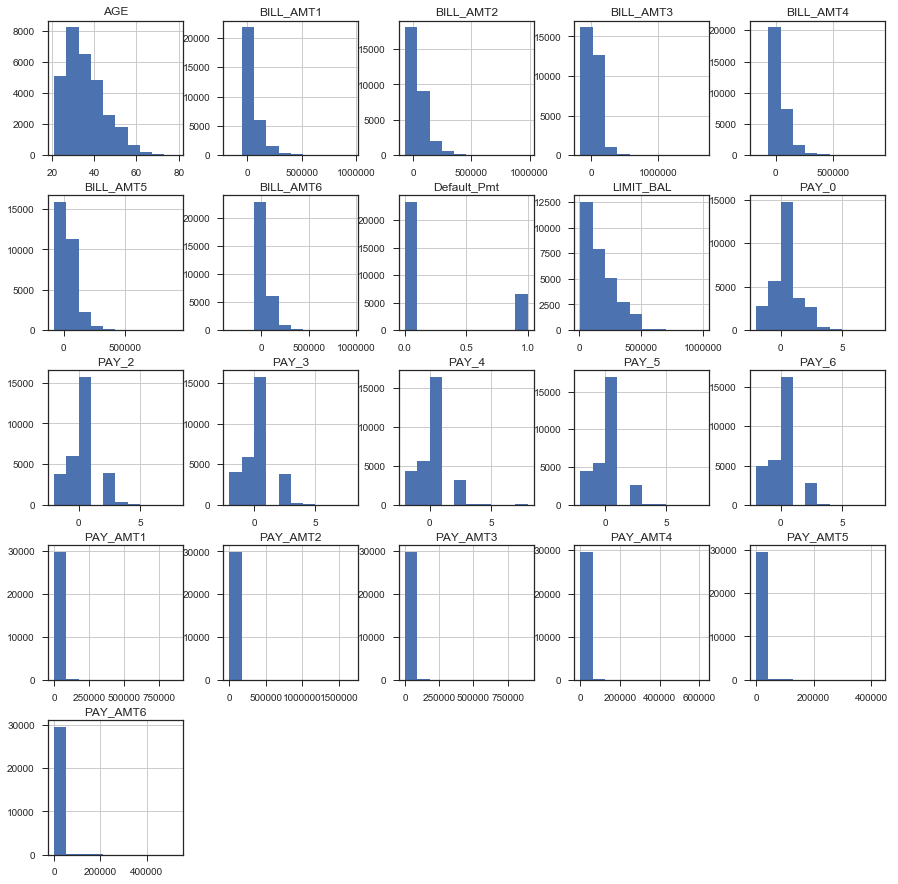

In [145]:
fig = plt.figure(figsize = (15,25))
ax = fig.gca()
taiwan.select_dtypes(exclude=['object']).hist(layout=(8,5), ax=ax)
plt.show()

<a id='visualize'></a>
## III. Visualizing Features and Their Ability to Predict Default

### German Dataset

In [146]:
# function to produce crosstabs and odds ratios for categorical variables
# https://en.wikipedia.org/wiki/Odds_ratio
def ctab_maker(df,label_var):
    for colname in df:
        if df[colname].dtype == 'object':
            testvar = pd.crosstab(df[colname],  # Make a crosstab
                df[label_var], margins = True) 
            for idx, val in enumerate(testvar):
                testvar['sum1'] = testvar.iloc[len(testvar)-1,1]
                testvar['other1'] = testvar['sum1'] - testvar.iloc[:,1]
                testvar['sum0'] = testvar.iloc[len(testvar)-1,0]
                testvar['other0'] = testvar['sum0'] - testvar.iloc[:,0]
                testvar['num'] = testvar.iloc[:,1] / testvar['other1']
                testvar['denom'] = testvar.iloc[:,0] / testvar['other0']
                testvar['oddsratio'] = testvar['num'] / testvar['denom']
            display(testvar)

In [147]:
ctab_maker(german, 'Default')

Default            0    1   All  sum1  other1  sum0  other0  num  denom  \
Checking_Status                                                           
A11              139  135   274   300     165   700     561 0.82   0.25   
A12              164  105   269   300     195   700     536 0.54   0.31   
A13               49   14    63   300     286   700     651 0.05   0.08   
A14              348   46   394   300     254   700     352 0.18   0.99   
All              700  300  1000   300       0   700       0  inf    inf   

Default          oddsratio  
Checking_Status             
A11                   3.30  
A12                   1.76  
A13                   0.65  
A14                   0.18  
All                    nan

Default           0    1   All  sum1  other1  sum0  other0  num  denom  \
Credit_History                                                           
A30              15   25    40   300     275   700     685 0.09   0.02   
A31              21   28    49   300     272   700     679 0.10   0.03   
A32             361  169   530   300     131   700     339 1.29   1.06   
A33              60   28    88   300     272   700     640 0.10   0.09   
A34             243   50   293   300     250   700     457 0.20   0.53   
All             700  300  1000   300       0   700       0  inf    inf   

Default         oddsratio  
Credit_History             
A30                  4.15  
A31                  3.33  
A32                  1.21  
A33                  1.10  
A34                  0.38  
All                   nan

Default         0    1   All  sum1  other1  sum0  other0  num  denom  \
Loan_Purpose                                                           
A40           145   89   234   300     211   700     555 0.42   0.26   
A41            86   17   103   300     283   700     614 0.06   0.14   
A410            7    5    12   300     295   700     693 0.02   0.01   
A42           123   58   181   300     242   700     577 0.24   0.21   
A43           218   62   280   300     238   700     482 0.26   0.45   
A44             8    4    12   300     296   700     692 0.01   0.01   
A45            14    8    22   300     292   700     686 0.03   0.02   
A46            28   22    50   300     278   700     672 0.08   0.04   
A48             8    1     9   300     299   700     692 0.00   0.01   
A49            63   34    97   300     266   700     637 0.13   0.10   
All           700  300  1000   300       0   700       0  inf    inf   

Default       oddsratio  
Loan_Purpose             
A40                1.61  
A41                0.43  
A410               1.68  
A42                1.12  
A43                0.58  
A44                1.17  
A45                1.34  
A46                1.90  
A48                0.29  
A49                1.29  
All                 nan

Default          0    1   All  sum1  other1  sum0  other0  num  denom  \
Savings-Bonds                                                           
A61            386  217   603   300      83   700     314 2.61   1.23   
A62             69   34   103   300     266   700     631 0.13   0.11   
A63             52   11    63   300     289   700     648 0.04   0.08   
A64             42    6    48   300     294   700     658 0.02   0.06   
A65            151   32   183   300     268   700     549 0.12   0.28   
All            700  300  1000   300       0   700       0  inf    inf   

Default        oddsratio  
Savings-Bonds             
A61                 2.13  
A62                 1.17  
A63                 0.47  
A64                 0.32  
A65                 0.43  
All                  nan

Default       0    1   All  sum1  other1  sum0  other0  num  denom  oddsratio
Employment                                                                   
A71          39   23    62   300     277   700     661 0.08   0.06       1.41
A72         102   70   172   300     230   700     598 0.30   0.17       1.78
A73         235  104   339   300     196   700     465 0.53   0.51       1.05
A74         135   39   174   300     261   700     565 0.15   0.24       0.63
A75         189   64   253   300     236   700     511 0.27   0.37       0.73
All         700  300  1000   300       0   700       0  inf    inf        nan

Default          0    1   All  sum1  other1  sum0  other0  num  denom  \
Gender-Status                                                           
A91             30   20    50   300     280   700     670 0.07   0.04   
A92            201  109   310   300     191   700     499 0.57   0.40   
A93            402  146   548   300     154   700     298 0.95   1.35   
A94             67   25    92   300     275   700     633 0.09   0.11   
All            700  300  1000   300       0   700       0  inf    inf   

Default        oddsratio  
Gender-Status             
A91                 1.60  
A92                 1.42  
A93                 0.70  
A94                 0.86  
All                  nan

Default      0    1   All  sum1  other1  sum0  other0  num  denom  oddsratio
Guarantor                                                                   
A101       635  272   907   300      28   700      65 9.71   9.77       0.99
A102        23   18    41   300     282   700     677 0.06   0.03       1.88
A103        42   10    52   300     290   700     658 0.03   0.06       0.54
All        700  300  1000   300       0   700       0  inf    inf        nan

Default     0    1   All  sum1  other1  sum0  other0  num  denom  oddsratio
Property                                                                   
A121      222   60   282   300     240   700     478 0.25   0.46       0.54
A122      161   71   232   300     229   700     539 0.31   0.30       1.04
A123      230  102   332   300     198   700     470 0.52   0.49       1.05
A124       87   67   154   300     233   700     613 0.29   0.14       2.03
All       700  300  1000   300       0   700       0  inf    inf        nan

Default       0    1   All  sum1  other1  sum0  other0  num  denom  oddsratio
Other_Inst                                                                   
A141         82   57   139   300     243   700     618 0.23   0.13       1.77
A142         28   19    47   300     281   700     672 0.07   0.04       1.62
A143        590  224   814   300      76   700     110 2.95   5.36       0.55
All         700  300  1000   300       0   700       0  inf    inf        nan

Default    0    1   All  sum1  other1  sum0  other0  num  denom  oddsratio
Housing                                                                   
A151     109   70   179   300     230   700     591 0.30   0.18       1.65
A152     527  186   713   300     114   700     173 1.63   3.05       0.54
A153      64   44   108   300     256   700     636 0.17   0.10       1.71
All      700  300  1000   300       0   700       0  inf    inf        nan

Default    0    1   All  sum1  other1  sum0  other0  num  denom  oddsratio
Job                                                                       
A171      15    7    22   300     293   700     685 0.02   0.02       1.09
A172     144   56   200   300     244   700     556 0.23   0.26       0.89
A173     444  186   630   300     114   700     256 1.63   1.73       0.94
A174      97   51   148   300     249   700     603 0.20   0.16       1.27
All      700  300  1000   300       0   700       0  inf    inf        nan

Default      0    1   All  sum1  other1  sum0  other0  num  denom  oddsratio
Telephone                                                                   
A191       409  187   596   300     113   700     291 1.65   1.41       1.18
A192       291  113   404   300     187   700     409 0.60   0.71       0.85
All        700  300  1000   300       0   700       0  inf    inf        nan

Default           0    1   All  sum1  other1  sum0  other0   num  denom  \
Foreign_Worker                                                            
A201            667  296   963   300       4   700      33 74.00  20.21   
A202             33    4    37   300     296   700     667  0.01   0.05   
All             700  300  1000   300       0   700       0   inf    inf   

Default         oddsratio  
Foreign_Worker             
A201                 3.66  
A202                 0.27  
All                   nan

In [148]:
# visualizing numerical features and ability to predict default
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

def boxplots(df,labelvar):
    plot_var = []
    df_num = df.select_dtypes(exclude=['object'])
    plot_var = list(df_num.columns.values)
    for var in plot_var:
        sns.boxplot(x=labelvar, y=var, data=df)
        plt.show()


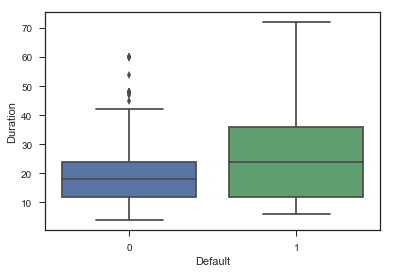

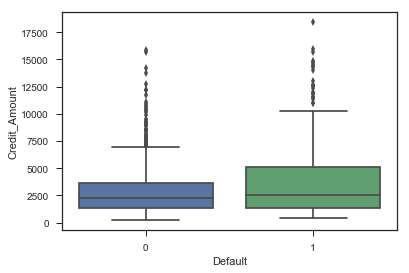

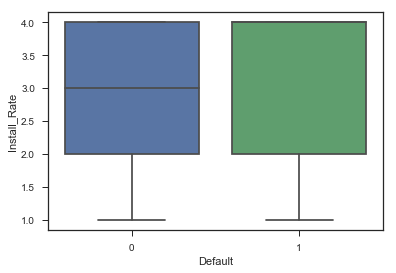

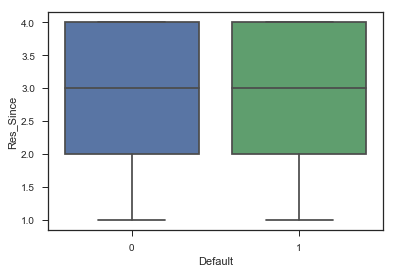

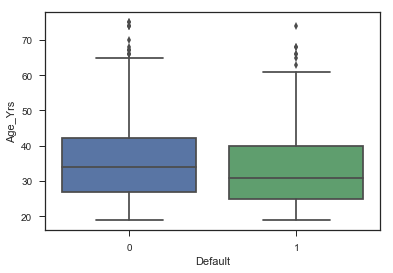

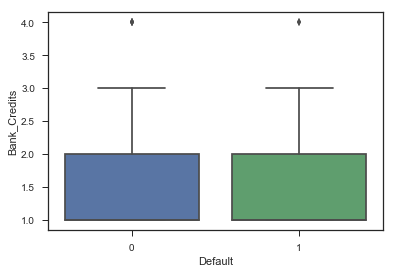

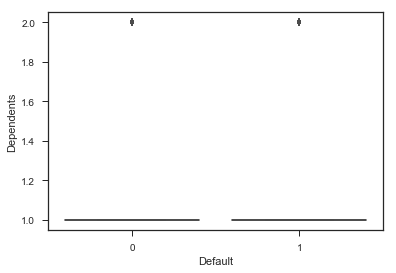

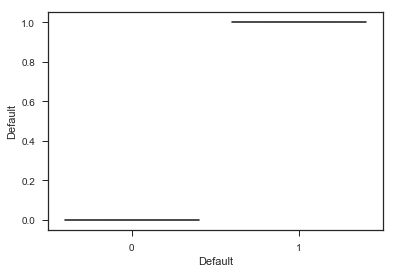

In [149]:
boxplots(german,'Default')

#### Australian Data

In [150]:
# Run crosstabs and oddss ratios
ctab_maker(aus, 'Default')

Default     0    1  All  sum1  other1  sum0  other0  num  denom  oddsratio
Feature1                                                                  
0         121  101  222   307     206   383     262 0.49   0.46       1.06
1         262  206  468   307     101   383     121 2.04   2.17       0.94
All       383  307  690   307       0   383       0  inf    inf        nan

Default     0    1  All  sum1  other1  sum0  other0  num  denom  oddsratio
Feature4                                                                  
1         118   45  163   307     262   383     265 0.17   0.45       0.39
2         265  260  525   307      47   383     118 5.53   2.25       2.46
3           0    2    2   307     305   383     383 0.01   0.00        inf
All       383  307  690   307       0   383       0  inf    inf        nan

Default     0    1  All  sum1  other1  sum0  other0  num  denom  oddsratio
Feature5                                                                  
1          46    7   53   307     300   383     337 0.02   0.14       0.17
2          23    7   30   307     300   383     360 0.02   0.06       0.37
3          45   14   59   307     293   383     338 0.05   0.13       0.36
4          37   14   51   307     293   383     346 0.05   0.11       0.45
5           7    3   10   307     304   383     376 0.01   0.02       0.53
6          35   19   54   307     288   383     348 0.07   0.10       0.66
7          22   16   38   307     291   383     361 0.05   0.06       0.90
8          80   66  146   307     241   383     303 0.27   0.26       1.04
9          31   33   64   307     274   383     352 0.12   0.09       1.37
10         11   14   25   307     293   383     372 0.05   0.03       1.62
11         27   51   78   307     256   383     356 0.20   0.08       2.63
12          1    2    3   307     305   383     382 0.01   0.00       2.50
13         12   29   41   307     278   383     371 0.10   0.03       3.23
14          6   32   38   307     275   383     377 0.12   0.02       7.31
All       383  307  690   307       0   383       0  inf    inf        nan

Default     0    1  All  sum1  other1  sum0  other0  num  denom  oddsratio
Feature6                                                                  
1          49    8   57   307     299   383     334 0.03   0.15       0.18
2           4    2    6   307     305   383     379 0.01   0.01       0.62
3           5    3    8   307     304   383     378 0.01   0.01       0.75
4         235  173  408   307     134   383     148 1.29   1.59       0.81
5          34   25   59   307     282   383     349 0.09   0.10       0.91
7           3    3    6   307     304   383     380 0.01   0.01       1.25
8          51   87  138   307     220   383     332 0.40   0.15       2.57
9           2    6    8   307     301   383     381 0.02   0.01       3.80
All       383  307  690   307       0   383       0  inf    inf        nan

Default     0    1  All  sum1  other1  sum0  other0   num  denom  oddsratio
Feature8                                                                   
0         306   23  329   307     284   383      77  0.08   3.97       0.02
1          77  284  361   307      23   383     306 12.35   0.25      49.07
All       383  307  690   307       0   383       0   inf    inf        nan

Default     0    1  All  sum1  other1  sum0  other0  num  denom  oddsratio
Feature9                                                                  
0         297   98  395   307     209   383      86 0.47   3.45       0.14
1          86  209  295   307      98   383     297 2.13   0.29       7.37
All       383  307  690   307       0   383       0  inf    inf        nan

Default      0    1  All  sum1  other1  sum0  other0  num  denom  oddsratio
Feature11                                                                  
0          213  161  374   307     146   383     170 1.10   1.25       0.88
1          170  146  316   307     161   383     213 0.91   0.80       1.14
All        383  307  690   307       0   383       0  inf    inf        nan

Default      0    1  All  sum1  other1  sum0  other0   num  denom  oddsratio
Feature12                                                                   
1           42   15   57   307     292   383     341  0.05   0.12       0.42
2          338  287  625   307      20   383      45 14.35   7.51       1.91
3            3    5    8   307     302   383     380  0.02   0.01       2.10
All        383  307  690   307       0   383       0   inf    inf        nan

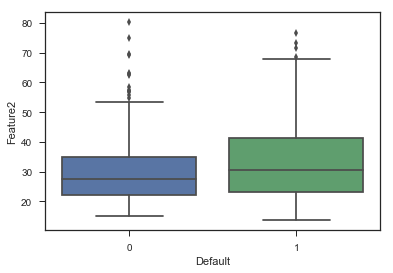

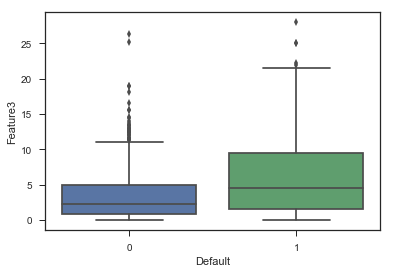

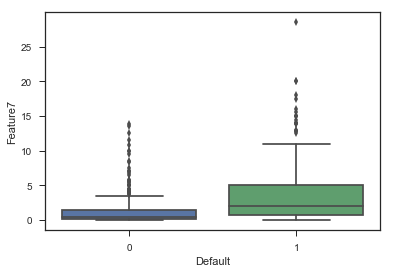

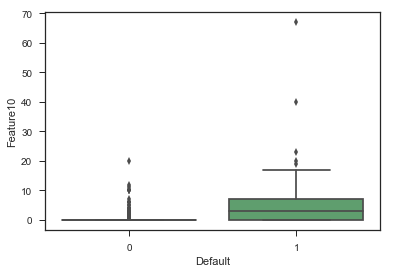

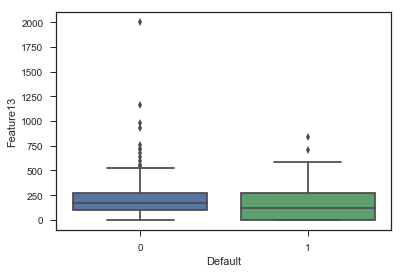

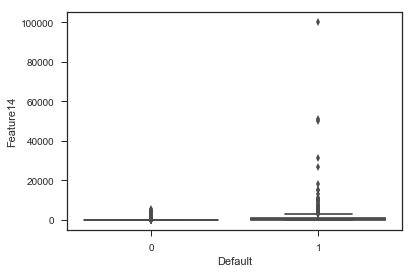

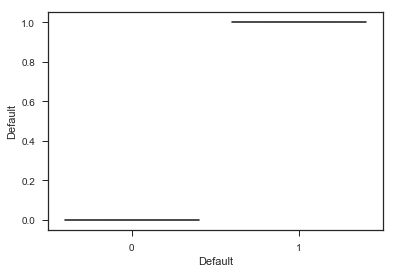

In [151]:
boxplots(aus,'Default')

#### Taiwan Data

In [152]:
# crosstabs and odds ratios for Taiwan data.
ctab_maker(taiwan, 'Default_Pmt')

Default_Pmt      0     1    All  sum1  other1   sum0  other0  num  denom  \
SEX                                                                        
1             9015  2873  11888  6636    3763  23364   14349 0.76   0.63   
2            14349  3763  18112  6636    2873  23364    9015 1.31   1.59   
All          23364  6636  30000  6636       0  23364       0  inf    inf   

Default_Pmt  oddsratio  
SEX                     
1                 1.22  
2                 0.82  
All                nan

Default_Pmt      0     1    All  sum1  other1   sum0  other0  num  denom  \
EDUCATION                                                                  
0               14     0     14  6636    6636  23364   23350 0.00   0.00   
1             8549  2036  10585  6636    4600  23364   14815 0.44   0.58   
2            10700  3330  14030  6636    3306  23364   12664 1.01   0.84   
3             3680  1237   4917  6636    5399  23364   19684 0.23   0.19   
4              116     7    123  6636    6629  23364   23248 0.00   0.00   
5              262    18    280  6636    6618  23364   23102 0.00   0.01   
6               43     8     51  6636    6628  23364   23321 0.00   0.00   
All          23364  6636  30000  6636       0  23364       0  inf    inf   

Default_Pmt  oddsratio  
EDUCATION               
0                 0.00  
1                 0.77  
2                 1.19  
3                 1.23  
4                 0.21  
5                 0.24  
6                 0.65  
All                nan

Default_Pmt      0     1    All  sum1  other1   sum0  other0  num  denom  \
MARRIAGE                                                                   
0               49     5     54  6636    6631  23364   23315 0.00   0.00   
1            10453  3206  13659  6636    3430  23364   12911 0.93   0.81   
2            12623  3341  15964  6636    3295  23364   10741 1.01   1.18   
3              239    84    323  6636    6552  23364   23125 0.01   0.01   
All          23364  6636  30000  6636       0  23364       0  inf    inf   

Default_Pmt  oddsratio  
MARRIAGE                
0                 0.36  
1                 1.15  
2                 0.86  
3                 1.24  
All                nan

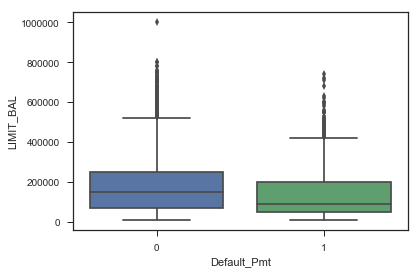

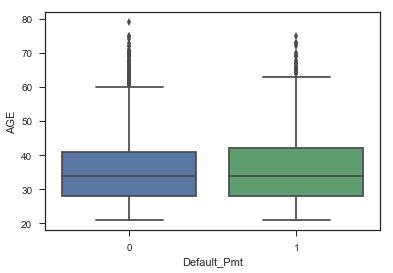

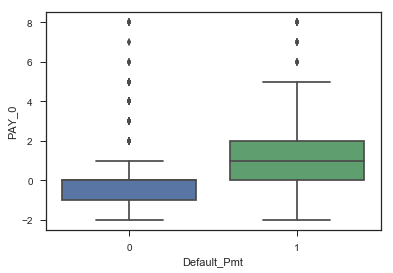

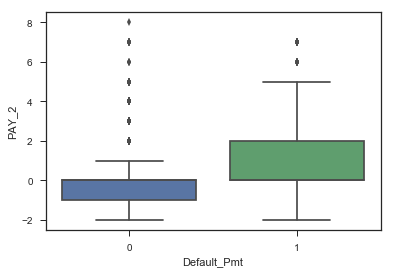

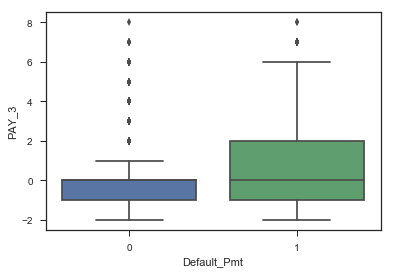

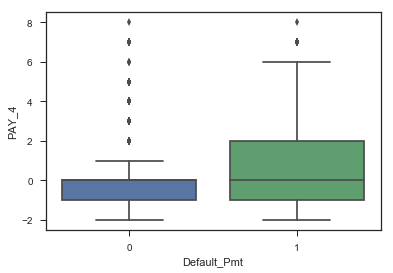

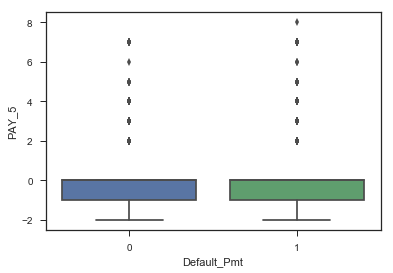

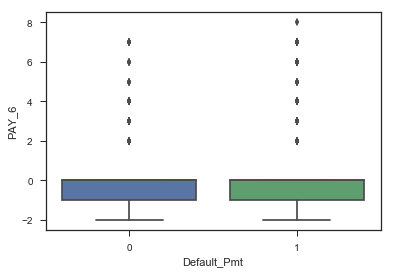

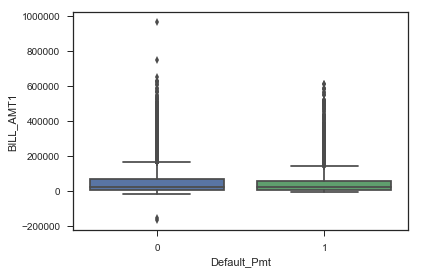

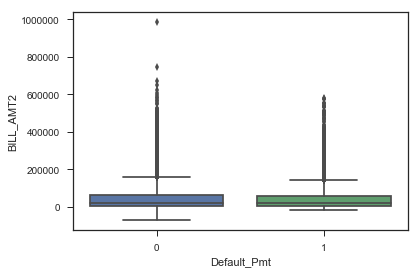

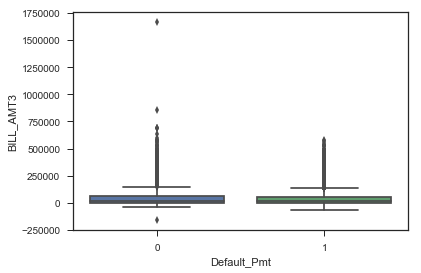

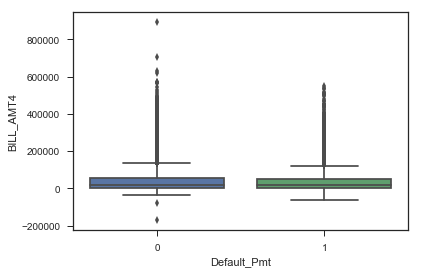

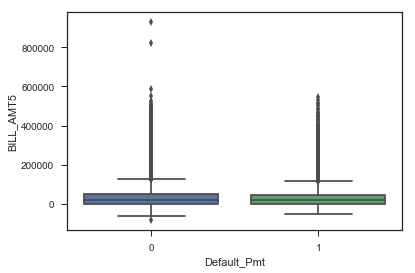

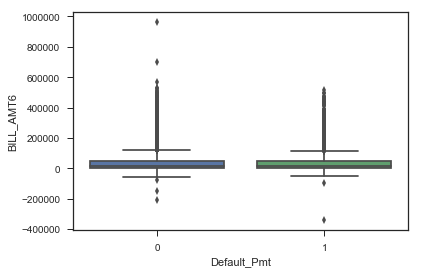

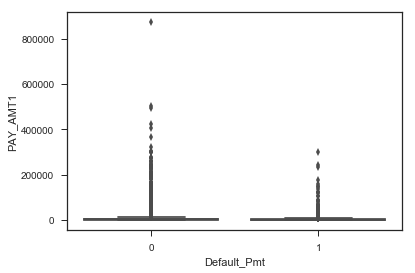

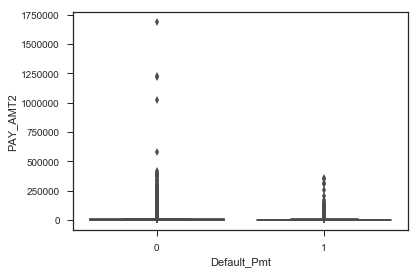

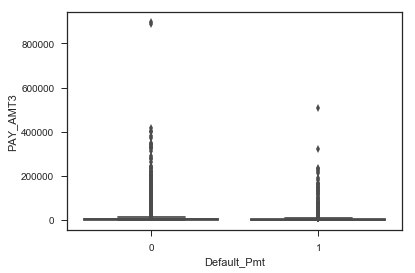

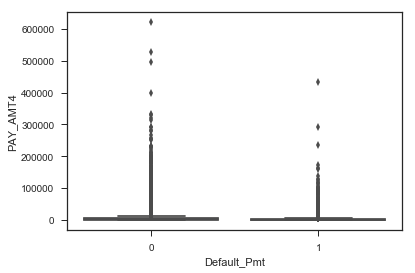

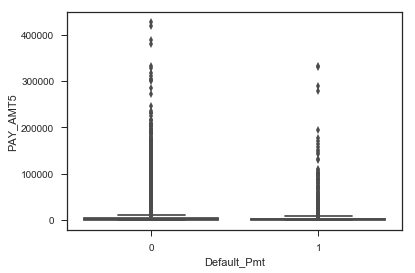

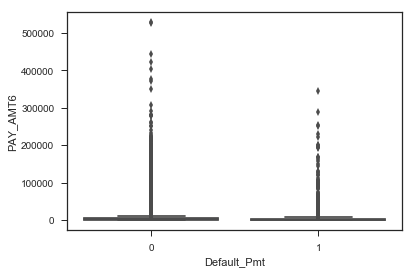

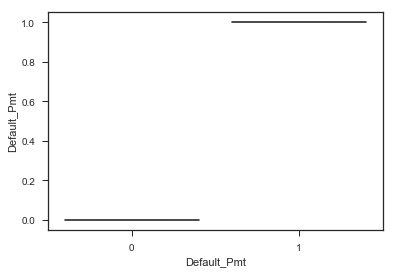

In [153]:
boxplots(taiwan,'Default_Pmt')

<a id='modelprep'></a>
## <b>IV. Model Preparation - Data Preprocessing</b>

In [154]:
# import utilities to aid preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as prep
from sklearn.preprocessing import OneHotEncoder

In [155]:
# check dataset contents - complete, looks good, commenting out
#display(german.dtypes)
#display(aus.dtypes)
#display(taiwan.dtypes)

In [156]:
# create one hot encodings for categorical variables
def cat_preproc(dataname,df):
    print('\n'+'Dataset: '+dataname)
    print('Creating dummy variables ...')

    df_cat = df.select_dtypes(include=['object'])
    print('Input shape for categorical features: '+str(df_cat.shape))

    dum_list = list(df_cat.columns.values) # features we want to convert
    dum_out = pd.get_dummies(data=df, columns=dum_list, drop_first=True) # create dummies
    print('Output shape for categorical features: '+str(dum_out.shape))    

    display(pd.DataFrame(dum_out).describe())

    return dum_out

In [157]:
# scale numeric data
def num_preproc(dataname,df,labelvar):
    df_num_feat = df.select_dtypes(exclude=['uint8']) # get dataframe of numeric features
    df_num = df_num_feat.drop(labelvar, axis=1) # remove label data
    num_list = list(df_num.columns.values) # list of features we want to convert    
    scaler = prep.StandardScaler() # define scaler
    df[num_list] = scaler.fit_transform(df[num_list]) # execute

    print('\n'+'Dataset: '+dataname)
    print('Scaling numeric variables ...')    
    print('Input shape for features: '+str(df_num.shape))
    print('Output shape for numeric features: '+str(df.shape))
    display(pd.DataFrame(df).describe())

    return df

In [158]:
# label encoding
def labenc(dataname,df,col):
    le = prep.LabelEncoder()
    df[col] = le.fit_transform(df[col])
    df[col] = df[col].astype('category')

    return df

In [159]:
# combine preprocesing steps
def preproc(dataname,df,labelvar):
    catout = cat_preproc(dataname,df)
    numout = num_preproc(dataname,catout,labelvar)
    preproc_out = labenc(dataname,numout,labelvar)

    return preproc_out

In [160]:
# Preprocess our 3 datasets
german_pre = preproc('German',german,'Default')   
aus_pre = preproc('Australian',aus,'Default')
taiwan_pre = preproc('Taiwan',taiwan,'Default_Pmt')



Dataset: German
Creating dummy variables ...
Input shape for categorical features: (1000, 13)
Output shape for categorical features: (1000, 49)


Duration  Credit_Amount  Install_Rate  Res_Since  Age_Yrs  \
count   1000.00        1000.00       1000.00    1000.00  1000.00   
mean      20.90        3271.26          2.97       2.85    35.55   
std       12.06        2822.74          1.12       1.10    11.38   
min        4.00         250.00          1.00       1.00    19.00   
25%       12.00        1365.50          2.00       2.00    27.00   
50%       18.00        2319.50          3.00       3.00    33.00   
75%       24.00        3972.25          4.00       4.00    42.00   
max       72.00       18424.00          4.00       4.00    75.00   

       Bank_Credits  Dependents  Default  Checking_Status_A12  \
count       1000.00     1000.00  1000.00              1000.00   
mean           1.41        1.16     0.30                 0.27   
std            0.58        0.36     0.46                 0.44   
min            1.00        1.00     0.00                 0.00   
25%            1.00        1.00     0.00                 0.00   
50%            1.00        1.00     0.00                 0.00   
75%            2.00        1.00     1.00                 1.00   
max            4.00        2.00     1.00                 1.00   

       Checking_Status_A13         ...           Property_A124  \
count              1000.00         ...                 1000.00   
mean                  0.06         ...                    0.15   
std                   0.24         ...                    0.36   
min                   0.00         ...                    0.00   
25%                   0.00         ...                    0.00   
50%                   0.00         ...                    0.00   
75%                   0.00         ...                    0.00   
max                   1.00         ...                    1.00   

       Other_Inst_A142  Other_Inst_A143  Housing_A152  Housing_A153  Job_A172  \
count          1000.00          1000.00       1000.00       1000.00   1000.00   
mean              0.05             0.81          0.71          0.11      0.20   
std               0.21             0.39          0.45          0.31      0.40   
min               0.00             0.00          0.00          0.00      0.00   
25%               0.00             1.00          0.00          0.00      0.00   
50%               0.00             1.00          1.00          0.00      0.00   
75%               0.00             1.00          1.00          0.00      0.00   
max               1.00             1.00          1.00          1.00      1.00   

       Job_A173  Job_A174  Telephone_A192  Foreign_Worker_A202  
count   1000.00   1000.00         1000.00              1000.00  
mean       0.63      0.15            0.40                 0.04  
std        0.48      0.36            0.49                 0.19  
min        0.00      0.00            0.00                 0.00  
25%        0.00      0.00            0.00                 0.00  
50%        1.00      0.00            0.00                 0.00  
75%        1.00      0.00            1.00                 0.00  
max        1.00      1.00            1.00                 1.00  

[8 rows x 49 columns]


Dataset: German
Scaling numeric variables ...
Input shape for features: (1000, 7)
Output shape for numeric features: (1000, 49)


Duration  Credit_Amount  Install_Rate  Res_Since  Age_Yrs  \
count   1000.00        1000.00       1000.00    1000.00  1000.00   
mean       0.00           0.00          0.00      -0.00     0.00   
std        1.00           1.00          1.00       1.00     1.00   
min       -1.40          -1.07         -1.76      -1.67    -1.46   
25%       -0.74          -0.68         -0.87      -0.77    -0.75   
50%       -0.24          -0.34          0.02       0.14    -0.22   
75%        0.26           0.25          0.92       1.05     0.57   
max        4.24           5.37          0.92       1.05     3.47   

       Bank_Credits  Dependents  Default  Checking_Status_A12  \
count       1000.00     1000.00  1000.00              1000.00   
mean          -0.00       -0.00     0.30                 0.27   
std            1.00        1.00     0.46                 0.44   
min           -0.70       -0.43     0.00                 0.00   
25%           -0.70       -0.43     0.00                 0.00   
50%           -0.70       -0.43     0.00                 0.00   
75%            1.03       -0.43     1.00                 1.00   
max            4.49        2.33     1.00                 1.00   

       Checking_Status_A13         ...           Property_A124  \
count              1000.00         ...                 1000.00   
mean                  0.06         ...                    0.15   
std                   0.24         ...                    0.36   
min                   0.00         ...                    0.00   
25%                   0.00         ...                    0.00   
50%                   0.00         ...                    0.00   
75%                   0.00         ...                    0.00   
max                   1.00         ...                    1.00   

       Other_Inst_A142  Other_Inst_A143  Housing_A152  Housing_A153  Job_A172  \
count          1000.00          1000.00       1000.00       1000.00   1000.00   
mean              0.05             0.81          0.71          0.11      0.20   
std               0.21             0.39          0.45          0.31      0.40   
min               0.00             0.00          0.00          0.00      0.00   
25%               0.00             1.00          0.00          0.00      0.00   
50%               0.00             1.00          1.00          0.00      0.00   
75%               0.00             1.00          1.00          0.00      0.00   
max               1.00             1.00          1.00          1.00      1.00   

       Job_A173  Job_A174  Telephone_A192  Foreign_Worker_A202  
count   1000.00   1000.00         1000.00              1000.00  
mean       0.63      0.15            0.40                 0.04  
std        0.48      0.36            0.49                 0.19  
min        0.00      0.00            0.00                 0.00  
25%        0.00      0.00            0.00                 0.00  
50%        1.00      0.00            0.00                 0.00  
75%        1.00      0.00            1.00                 0.00  
max        1.00      1.00            1.00                 1.00  

[8 rows x 49 columns]


Dataset: Australian
Creating dummy variables ...
Input shape for categorical features: (690, 8)
Output shape for categorical features: (690, 35)


Feature2  Feature3  Feature7  Feature10  Feature13  Feature14  Default  \
count    690.00    690.00    690.00     690.00     690.00     690.00   690.00   
mean      31.57      4.76      2.22       2.40     184.01    1018.39     0.44   
std       11.85      4.98      3.35       4.86     172.16    5210.10     0.50   
min       13.75      0.00      0.00       0.00       0.00       1.00     0.00   
25%       22.67      1.00      0.17       0.00      80.00       1.00     0.00   
50%       28.62      2.75      1.00       0.00     160.00       6.00     0.00   
75%       37.71      7.21      2.62       3.00     272.00     396.50     1.00   
max       80.25     28.00     28.50      67.00    2000.00  100001.00     1.00   

       Feature1_1  Feature4_2  Feature4_3     ...       Feature6_4  \
count      690.00      690.00      690.00     ...           690.00   
mean         0.68        0.76        0.00     ...             0.59   
std          0.47        0.43        0.05     ...             0.49   
min          0.00        0.00        0.00     ...             0.00   
25%          0.00        1.00        0.00     ...             0.00   
50%          1.00        1.00        0.00     ...             1.00   
75%          1.00        1.00        0.00     ...             1.00   
max          1.00        1.00        1.00     ...             1.00   

       Feature6_5  Feature6_7  Feature6_8  Feature6_9  Feature8_1  Feature9_1  \
count      690.00      690.00      690.00      690.00      690.00      690.00   
mean         0.09        0.01        0.20        0.01        0.52        0.43   
std          0.28        0.09        0.40        0.11        0.50        0.50   
min          0.00        0.00        0.00        0.00        0.00        0.00   
25%          0.00        0.00        0.00        0.00        0.00        0.00   
50%          0.00        0.00        0.00        0.00        1.00        0.00   
75%          0.00        0.00        0.00        0.00        1.00        1.00   
max          1.00        1.00        1.00        1.00        1.00        1.00   

       Feature11_1  Feature12_2  Feature12_3  
count       690.00       690.00       690.00  
mean          0.46         0.91         0.01  
std           0.50         0.29         0.11  
min           0.00         0.00         0.00  
25%           0.00         1.00         0.00  
50%           0.00         1.00         0.00  
75%           1.00         1.00         0.00  
max           1.00         1.00         1.00  

[8 rows x 35 columns]


Dataset: Australian
Scaling numeric variables ...
Input shape for features: (690, 6)
Output shape for numeric features: (690, 35)


Feature2  Feature3  Feature7  Feature10  Feature13  Feature14  Default  \
count    690.00    690.00    690.00     690.00     690.00     690.00   690.00   
mean       0.00      0.00      0.00       0.00       0.00       0.00     0.44   
std        1.00      1.00      1.00       1.00       1.00       1.00     0.50   
min       -1.50     -0.96     -0.66      -0.49      -1.07      -0.20     0.00   
25%       -0.75     -0.76     -0.62      -0.49      -0.60      -0.20     0.00   
50%       -0.25     -0.40     -0.37      -0.49      -0.14      -0.19     0.00   
75%        0.52      0.49      0.12       0.12       0.51      -0.12     1.00   
max        4.11      4.67      7.86      13.29      10.56      19.01     1.00   

       Feature1_1  Feature4_2  Feature4_3     ...       Feature6_4  \
count      690.00      690.00      690.00     ...           690.00   
mean         0.68        0.76        0.00     ...             0.59   
std          0.47        0.43        0.05     ...             0.49   
min          0.00        0.00        0.00     ...             0.00   
25%          0.00        1.00        0.00     ...             0.00   
50%          1.00        1.00        0.00     ...             1.00   
75%          1.00        1.00        0.00     ...             1.00   
max          1.00        1.00        1.00     ...             1.00   

       Feature6_5  Feature6_7  Feature6_8  Feature6_9  Feature8_1  Feature9_1  \
count      690.00      690.00      690.00      690.00      690.00      690.00   
mean         0.09        0.01        0.20        0.01        0.52        0.43   
std          0.28        0.09        0.40        0.11        0.50        0.50   
min          0.00        0.00        0.00        0.00        0.00        0.00   
25%          0.00        0.00        0.00        0.00        0.00        0.00   
50%          0.00        0.00        0.00        0.00        1.00        0.00   
75%          0.00        0.00        0.00        0.00        1.00        1.00   
max          1.00        1.00        1.00        1.00        1.00        1.00   

       Feature11_1  Feature12_2  Feature12_3  
count       690.00       690.00       690.00  
mean          0.46         0.91         0.01  
std           0.50         0.29         0.11  
min           0.00         0.00         0.00  
25%           0.00         1.00         0.00  
50%           0.00         1.00         0.00  
75%           1.00         1.00         0.00  
max           1.00         1.00         1.00  

[8 rows x 35 columns]


Dataset: Taiwan
Creating dummy variables ...
Input shape for categorical features: (30000, 3)
Output shape for categorical features: (30000, 31)


LIMIT_BAL      AGE    PAY_0    PAY_2    PAY_3    PAY_4    PAY_5  \
count   30000.00 30000.00 30000.00 30000.00 30000.00 30000.00 30000.00   
mean   167484.32    35.49    -0.02    -0.13    -0.17    -0.22    -0.27   
std    129747.66     9.22     1.12     1.20     1.20     1.17     1.13   
min     10000.00    21.00    -2.00    -2.00    -2.00    -2.00    -2.00   
25%     50000.00    28.00    -1.00    -1.00    -1.00    -1.00    -1.00   
50%    140000.00    34.00     0.00     0.00     0.00     0.00     0.00   
75%    240000.00    41.00     0.00     0.00     0.00     0.00     0.00   
max   1000000.00    79.00     8.00     8.00     8.00     8.00     8.00   

         PAY_6  BILL_AMT1  BILL_AMT2     ...        SEX_2  EDUCATION_1  \
count 30000.00   30000.00   30000.00     ...     30000.00     30000.00   
mean     -0.29   51223.33   49179.08     ...         0.60         0.35   
std       1.15   73635.86   71173.77     ...         0.49         0.48   
min      -2.00 -165580.00  -69777.00     ...         0.00         0.00   
25%      -1.00    3558.75    2984.75     ...         0.00         0.00   
50%       0.00   22381.50   21200.00     ...         1.00         0.00   
75%       0.00   67091.00   64006.25     ...         1.00         1.00   
max       8.00  964511.00  983931.00     ...         1.00         1.00   

       EDUCATION_2  EDUCATION_3  EDUCATION_4  EDUCATION_5  EDUCATION_6  \
count     30000.00     30000.00     30000.00     30000.00     30000.00   
mean          0.47         0.16         0.00         0.01         0.00   
std           0.50         0.37         0.06         0.10         0.04   
min           0.00         0.00         0.00         0.00         0.00   
25%           0.00         0.00         0.00         0.00         0.00   
50%           0.00         0.00         0.00         0.00         0.00   
75%           1.00         0.00         0.00         0.00         0.00   
max           1.00         1.00         1.00         1.00         1.00   

       MARRIAGE_1  MARRIAGE_2  MARRIAGE_3  
count    30000.00    30000.00    30000.00  
mean         0.46        0.53        0.01  
std          0.50        0.50        0.10  
min          0.00        0.00        0.00  
25%          0.00        0.00        0.00  
50%          0.00        1.00        0.00  
75%          1.00        1.00        0.00  
max          1.00        1.00        1.00  

[8 rows x 31 columns]


Dataset: Taiwan
Scaling numeric variables ...
Input shape for features: (30000, 20)
Output shape for numeric features: (30000, 31)


LIMIT_BAL      AGE    PAY_0    PAY_2    PAY_3    PAY_4    PAY_5  \
count   30000.00 30000.00 30000.00 30000.00 30000.00 30000.00 30000.00   
mean        0.00    -0.00    -0.00    -0.00    -0.00    -0.00    -0.00   
std         1.00     1.00     1.00     1.00     1.00     1.00     1.00   
min        -1.21    -1.57    -1.76    -1.56    -1.53    -1.52    -1.53   
25%        -0.91    -0.81    -0.87    -0.72    -0.70    -0.67    -0.65   
50%        -0.21    -0.16     0.01     0.11     0.14     0.19     0.23   
75%         0.56     0.60     0.01     0.11     0.14     0.19     0.23   
max         6.42     4.72     7.13     6.79     6.82     7.03     7.29   

         PAY_6  BILL_AMT1  BILL_AMT2     ...        SEX_2  EDUCATION_1  \
count 30000.00   30000.00   30000.00     ...     30000.00     30000.00   
mean     -0.00       0.00      -0.00     ...         0.60         0.35   
std       1.00       1.00       1.00     ...         0.49         0.48   
min      -1.49      -2.94      -1.67     ...         0.00         0.00   
25%      -0.62      -0.65      -0.65     ...         0.00         0.00   
50%       0.25      -0.39      -0.39     ...         1.00         0.00   
75%       0.25       0.22       0.21     ...         1.00         1.00   
max       7.21      12.40      13.13     ...         1.00         1.00   

       EDUCATION_2  EDUCATION_3  EDUCATION_4  EDUCATION_5  EDUCATION_6  \
count     30000.00     30000.00     30000.00     30000.00     30000.00   
mean          0.47         0.16         0.00         0.01         0.00   
std           0.50         0.37         0.06         0.10         0.04   
min           0.00         0.00         0.00         0.00         0.00   
25%           0.00         0.00         0.00         0.00         0.00   
50%           0.00         0.00         0.00         0.00         0.00   
75%           1.00         0.00         0.00         0.00         0.00   
max           1.00         1.00         1.00         1.00         1.00   

       MARRIAGE_1  MARRIAGE_2  MARRIAGE_3  
count    30000.00    30000.00    30000.00  
mean         0.46        0.53        0.01  
std          0.50        0.50        0.10  
min          0.00        0.00        0.00  
25%          0.00        0.00        0.00  
50%          0.00        1.00        0.00  
75%          1.00        1.00        0.00  
max          1.00        1.00        1.00  

[8 rows x 31 columns]

In [161]:
#  Create train, validate, test sets
def splitter(dataname, data, label, test_size, test_size2):
    labels = data[label]
    features = data.drop(label, axis = 1)
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state = 7798520)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=test_size2, random_state = 8675309)

    # print dataset metrics
    print('Dataset: '+str(dataname))
    print('\n'+'Splitting into train, validate, and test sets . . . \n')
    print('There are %d training observations.' % len(x_train))
    print('There are %d validation observations.' % len(x_val))
    print('There are %d test observations.'% len(x_test))
    print('\n'+'Shape of the label datasets: \n'+'y_train: '+str(y_train.shape))
    print('y_val: '+str(y_val.shape))
    print('y_test: '+str(y_test.shape)+'\n')

    return x_train, x_test, x_val, y_train, y_test, y_val

In [162]:
# Do train, test, validate splilts for our 3 datasets
ger_x_train, ger_x_test, ger_x_val, ger_y_train, ger_y_test, ger_y_val = splitter(
    'German',german_pre,'Default',.2,.5)

aus_x_train, aus_x_test, aus_x_val, aus_y_train, aus_y_test, aus_y_val = splitter(
    'Australian',aus_pre,'Default',.23,.5)

tai_x_train, tai_x_test, tai_x_val, tai_y_train, tai_y_test, tai_y_val = splitter(
    'Taiwan',taiwan_pre,'Default_Pmt',.15,.5)

Dataset: German

Splitting into train, validate, and test sets . . . 

There are 800 training observations.
There are 100 validation observations.
There are 100 test observations.

Shape of the label datasets: 
y_train: (800,)
y_val: (100,)
y_test: (100,)

Dataset: Australian

Splitting into train, validate, and test sets . . . 

There are 531 training observations.
There are 80 validation observations.
There are 79 test observations.

Shape of the label datasets: 
y_train: (531,)
y_val: (80,)
y_test: (79,)

Dataset: Taiwan

Splitting into train, validate, and test sets . . . 

There are 25500 training observations.
There are 2250 validation observations.
There are 2250 test observations.

Shape of the label datasets: 
y_train: (25500,)
y_val: (2250,)
y_test: (2250,)



<a id='estimation1'></a>
## V. Model Estimation - First Round

### Logistic Regression

In [163]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Build the logistic regression model
def log_mod(dataset,technique,x_train,x_test,x_val,y_train,y_test,y_val):
    # train model
    LogReg = LogisticRegression()
    tuned_parameters = {'C': [0.1, 0.5, 1, 5, 10, 50, 100]}
    grid = GridSearchCV(LogisticRegression(solver='liblinear'), tuned_parameters, cv=3, scoring = 'accuracy', )
    grid.fit(x_train, y_train)  
    
    # create predictions: classes & probabilities
    y_pred_class = grid.predict(x_val)
    y_pred_prob = np.array(grid.predict_proba(x_val)[:,1])
    
    # diagnostics
    x, accscore = class_diag(y_val, y_pred_class, y_pred_prob)
    
    # Train, test, validation error
    train_error, test_error, valid_error = model_error(x_train,y_train,x_test,y_test,x_val,y_val,grid)
    print('Train error: '+str(train_error))
    print('Test error: '+str(test_error))
    print('Validation error: '+str(valid_error))    
    
    # add row to output report
    add_row = report_results_to_df(dataset,technique,x)
    acclist = [dataset, technique, accscore]
    return x, add_row, acclist
    

In [164]:
# Classification diagnostics

from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def class_diag(y_val, y_pred_class, y_pred_prob):
    con_mat = confusion_matrix(y_val, y_pred_class) # confusion matrix
    print('Confusion Matrix: ')
    display(con_mat)

    print('\n'+'Accuracy Score: '+'\n')
    accscore = accuracy_score(y_val, y_pred_class)
    display(accscore)
    
    crpt = classification_report(y_val, y_pred_class) # classification report
    print('\n'+'Classification Report: '+'\n'+crpt)
    
    fpr, tpr, _ = metrics.roc_curve(y_val, y_pred_prob) # roc curve
    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))

    plt.figure(0) 
    plt.step(fpr, tpr, color='b', alpha=0.2,
             where='post')
    plt.fill_between(fpr, tpr, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('ROC curve')

    average_precision = average_precision_score(y_val, y_pred_prob) # average precision
    display('Average precision-recall score: {0:0.2f}'.format(
        average_precision))

    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob) # precision recall curve
    plt.figure(1)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    return crpt, accscore

In [165]:
# Output classification report
# adapted from https://stackoverflow.com/questions/45003577/classification-report-in-sklearn

from sklearn.metrics import classification_report

def report_results_to_df(dataset,technique,report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[1]
        row['precision'] = float(row_data[2])
        row['recall'] = float(row_data[3])
        row['f1_score'] = float(row_data[4])
        row['support'] = int(row_data[5])
        row['dataset'] = dataset
        row['technique'] = technique
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    
    return dataframe


In [166]:
# Calculate RMSE for test and validation sets to evaluate model robustness

import numpy as np
from sklearn.metrics import mean_squared_error

def calc_error(X_set, y_set, model_name):
    preds = model_name.predict(X_set)
    mse = mean_squared_error(y_set, preds)
    rmse = np.sqrt(mse)
    return mse
    
def model_error(X_train, y_train, X_test, y_test, X_valid, y_valid, model_name):
    # report train, test, validation errors
    train_error = calc_error(X_train, y_train, model_name)
    test_error = calc_error(X_test, y_test, model_name)
    valid_error = calc_error(X_valid, y_valid, model_name)
    return train_error, test_error, valid_error

In [167]:
# Create empty dataframes to store model accuracy results
columns = ['class','dataset', 'f1_score', 'precision','recall','support','technique']
results = pd.DataFrame(columns=columns)
results.drop(results.index, inplace=True)

accscore_columns = ['dataset', 'accuracy_score', 'technique']
acc_results = pd.DataFrame(columns=accscore_columns)
acc_results.drop(results.index, inplace=True)

Confusion Matrix: 


array([[54, 11],
       [15, 20]])


Accuracy Score: 



0.73999999999999999


Classification Report: 
             precision    recall  f1-score   support

          0       0.78      0.83      0.81        65
          1       0.65      0.57      0.61        35

avg / total       0.73      0.74      0.74       100



'Average precision-recall score: 0.69'

Train error: 0.20125
Test error: 0.25
Validation error: 0.26


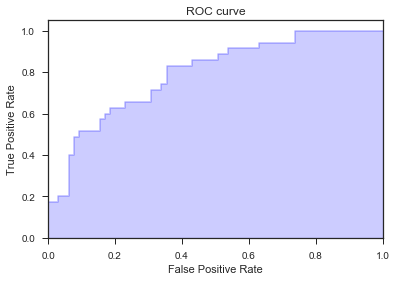

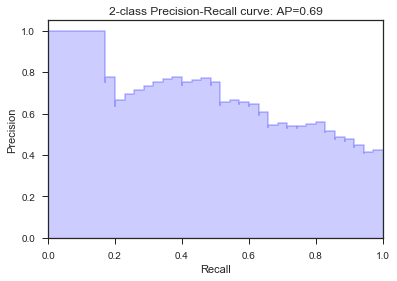

In [168]:
# Run the Logistic Regression model using the German data

x, mod_results, mod_acc = log_mod('Germany','Logistic',ger_x_train, ger_x_test, ger_x_val, ger_y_train, ger_y_test, ger_y_val)
results = pd.concat([results, mod_results])
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)


Confusion Matrix: 


array([[36,  4],
       [ 6, 34]])


Accuracy Score: 



0.875


Classification Report: 
             precision    recall  f1-score   support

          0       0.86      0.90      0.88        40
          1       0.89      0.85      0.87        40

avg / total       0.88      0.88      0.87        80



'Average precision-recall score: 0.96'

Train error: 0.148775894539
Test error: 0.0379746835443
Validation error: 0.125


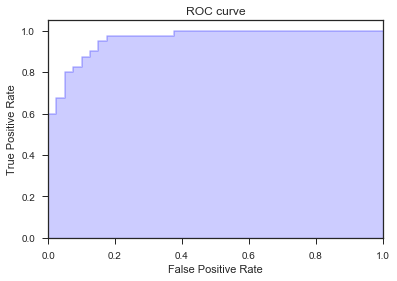

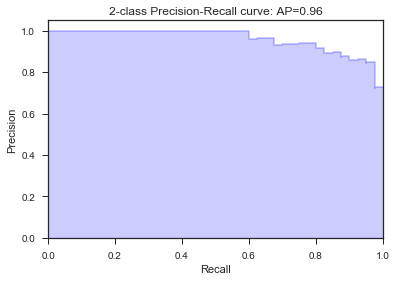

In [169]:
# Run the Logistic Regression model using the Australian data
x, mod_results, mod_acc = log_mod('Australia','Logistic',aus_x_train, aus_x_test, aus_x_val, aus_y_train, aus_y_test, aus_y_val)
results = pd.concat([results, mod_results])
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)


Confusion Matrix: 


array([[1682,   40],
       [ 397,  131]])


Accuracy Score: 



0.80577777777777781


Classification Report: 
             precision    recall  f1-score   support

          0       0.81      0.98      0.89      1722
          1       0.77      0.25      0.37       528

avg / total       0.80      0.81      0.77      2250



'Average precision-recall score: 0.54'

Train error: 0.187725490196
Test error: 0.197333333333
Validation error: 0.194222222222


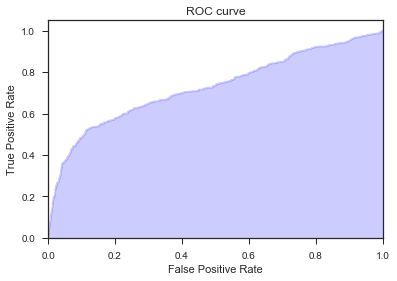

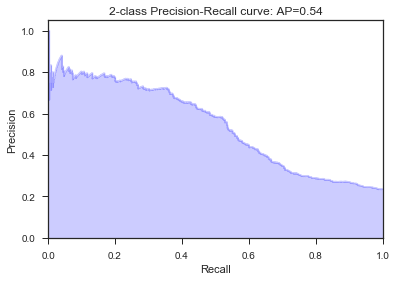

In [170]:
# Run the Logistic Regression model using the Taiwan data
x, mod_results, mod_acc = log_mod('Taiwan','Logistic',tai_x_train, tai_x_test, tai_x_val, tai_y_train, tai_y_test, tai_y_val)
results = pd.concat([results, mod_results])
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)


### Classification Trees

In [171]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

def tree_mod(dataset, technique, x_train,x_test,x_val,y_train,y_test,y_val):
    tuned_parameters = {'max_depth': np.arange(3,20)}
    grid = GridSearchCV(DecisionTreeClassifier(criterion='gini'), tuned_parameters)
    grid.fit(x_train, y_train)    

    # create predictions: classes & probabilities
    y_pred_class = grid.predict(x_val)
    y_pred_prob = np.array(grid.predict_proba(x_val)[:,1])
    
    # diagnostics
    x, accscore = class_diag(y_val, y_pred_class, y_pred_prob)

    # Train, test, validation error
    train_error, test_error, valid_error = model_error(x_train,y_train,x_test,y_test,x_val,y_val,grid)
    print('Train error: '+str(train_error))
    print('Test error: '+str(test_error))
    print('Validation error: '+str(valid_error))        
    
    # add row to output report
    add_row = report_results_to_df(dataset,technique,x)
    acclist = [dataset, technique, accscore]

    return x, add_row, acclist

Confusion Matrix: 


array([[60,  5],
       [27,  8]])


Accuracy Score: 



0.68000000000000005


Classification Report: 
             precision    recall  f1-score   support

          0       0.69      0.92      0.79        65
          1       0.62      0.23      0.33        35

avg / total       0.66      0.68      0.63       100



'Average precision-recall score: 0.51'

Train error: 0.2025
Test error: 0.37
Validation error: 0.32


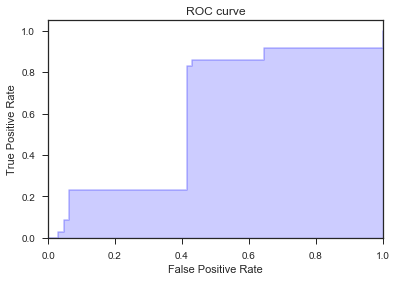

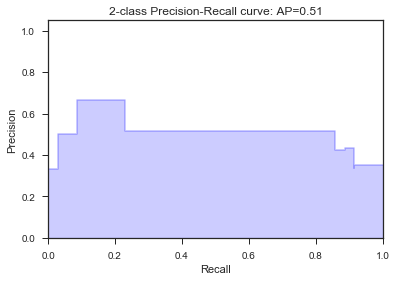

In [172]:
x, mod_results, mod_acc = tree_mod('Germany','Class Tree',ger_x_train, ger_x_test, ger_x_val, ger_y_train, ger_y_test, ger_y_val)
results = pd.concat([results, mod_results])
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)




Confusion Matrix: 


array([[37,  3],
       [ 5, 35]])


Accuracy Score: 



0.90000000000000002


Classification Report: 
             precision    recall  f1-score   support

          0       0.88      0.93      0.90        40
          1       0.92      0.88      0.90        40

avg / total       0.90      0.90      0.90        80



'Average precision-recall score: 0.94'

Train error: 0.114877589454
Test error: 0.0632911392405
Validation error: 0.1


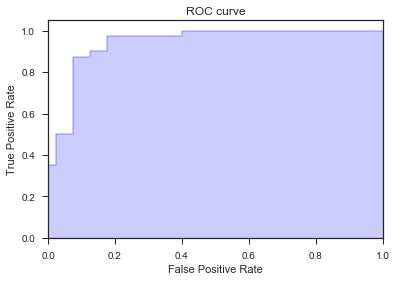

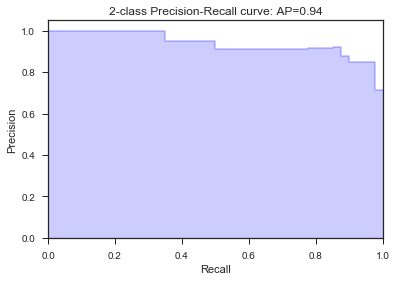

In [173]:
x, mod_results, mod_acc = tree_mod('Australia','Class Tree',aus_x_train, aus_x_test, aus_x_val, aus_y_train, aus_y_test, aus_y_val)
results = pd.concat([results, mod_results])
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)


Confusion Matrix: 


array([[1639,   83],
       [ 333,  195]])


Accuracy Score: 



0.81511111111111112


Classification Report: 
             precision    recall  f1-score   support

          0       0.83      0.95      0.89      1722
          1       0.70      0.37      0.48       528

avg / total       0.80      0.82      0.79      2250



'Average precision-recall score: 0.50'

Train error: 0.176431372549
Test error: 0.192444444444
Validation error: 0.184888888889


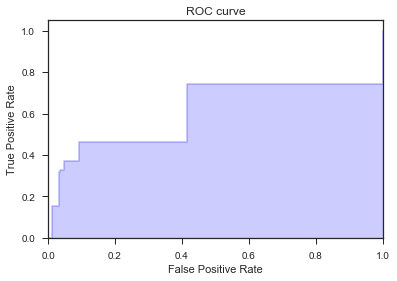

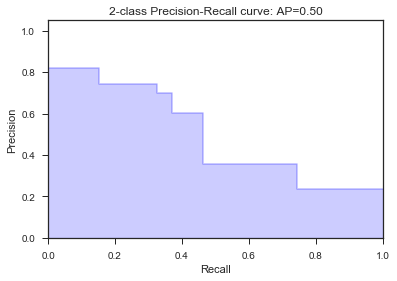

In [174]:
# Run the classification model using the Taiwan data
x, mod_results, mod_acc = tree_mod('Taiwan','Class Tree',tai_x_train, tai_x_test, tai_x_val, tai_y_train, tai_y_test, tai_y_val)
results = pd.concat([results, mod_results])
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)


### Support Vector Machines

In [175]:
# As I was estimating the SVM, I couldn't get it to complete - it took forever. A little online research suggested
# using stochastic gradient descent to speed things up:
# https://stackoverflow.com/questions/23056460/does-the-svm-in-sklearn-support-incremental-online-learning
# Using sklearn's SGDClassifier with a "hinge" loss and L2 regularization will give us a faster SVM.

# Please note this SVM setup does not appear to allow for export of predicted probabilities, thus precision/recall 
# curves are built off of the predicted class only

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

def svm_mod(dataset,technique,x_train,x_test,x_val,y_train,y_test,y_val):
    param_grid = {'loss':['hinge'],
                  'penalty':['l2'],
                  'shuffle':[True]}
    sgdc = SGDClassifier(max_iter=100, tol=None, random_state=8675309, shuffle=True)
    grid_search_sgdc = GridSearchCV(sgdc, param_grid=param_grid)
    grid_search_sgdc.fit(x_train, y_train)
    print(grid_search_sgdc.best_params_)
    print(grid_search_sgdc)

    # create predictions: classes & probabilities
    y_pred_class = grid_search_sgdc.predict(x_val)
    #y_pred_prob = np.array(grid_search_sgdc.predict_proba(x_val)[:,1])
    
    # diagnostics
    x, accscore = class_diag(y_val, y_pred_class, y_pred_class)

    # Train, test, validation error
    train_error, test_error, valid_error = model_error(x_train,y_train,x_test,y_test,x_val,y_val,grid_search_sgdc)
    print('Train error: '+str(train_error))
    print('Test error: '+str(test_error))
    print('Validation error: '+str(valid_error))    
    
    # add row to output report
    add_row = report_results_to_df(dataset,technique,x)
    acclist = [dataset, technique, accscore]

    return x, add_row, acclist

{'loss': 'hinge', 'penalty': 'l2', 'shuffle': True}
GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=8675309,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['hinge'], 'penalty': ['l2'], 'shuffle': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
Confusion Matrix: 


array([[56,  9],
       [19, 16]])


Accuracy Score: 



0.71999999999999997


Classification Report: 
             precision    recall  f1-score   support

          0       0.75      0.86      0.80        65
          1       0.64      0.46      0.53        35

avg / total       0.71      0.72      0.71       100



'Average precision-recall score: 0.48'

Train error: 0.20625
Test error: 0.25
Validation error: 0.28


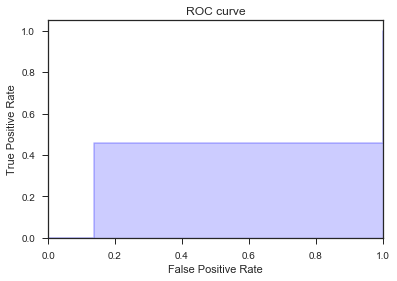

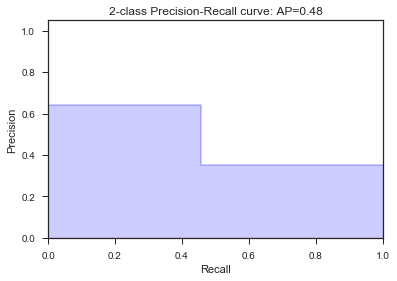

In [176]:
# SVM classification on Germany data
x, mod_results, mod_acc = svm_mod('Germany','SVM',ger_x_train, ger_x_test, ger_x_val, ger_y_train, ger_y_test, ger_y_val)
results = pd.concat([results, mod_results])
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)


{'loss': 'hinge', 'penalty': 'l2', 'shuffle': True}
GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=8675309,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['hinge'], 'penalty': ['l2'], 'shuffle': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
Confusion Matrix: 


array([[37,  3],
       [ 9, 31]])


Accuracy Score: 



0.84999999999999998


Classification Report: 
             precision    recall  f1-score   support

          0       0.80      0.93      0.86        40
          1       0.91      0.78      0.84        40

avg / total       0.86      0.85      0.85        80



'Average precision-recall score: 0.82'

Train error: 0.160075329567
Test error: 0.0759493670886
Validation error: 0.15


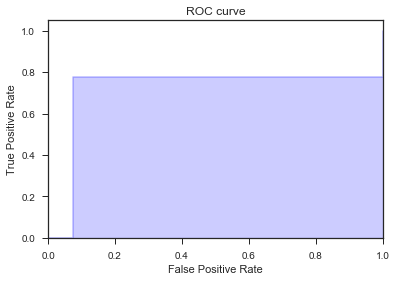

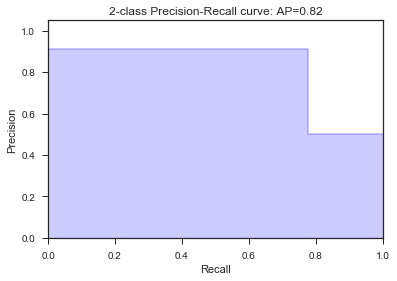

In [177]:
x, mod_results, mod_acc = svm_mod('Australia','SVM',aus_x_train, aus_x_test, aus_x_val, aus_y_train, aus_y_test, aus_y_val)
results = pd.concat([results, mod_results])
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)


{'loss': 'hinge', 'penalty': 'l2', 'shuffle': True}
GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=8675309,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['hinge'], 'penalty': ['l2'], 'shuffle': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
Confusion Matrix: 


array([[1669,   53],
       [ 396,  132]])


Accuracy Score: 



0.8004444444444444


Classification Report: 
             precision    recall  f1-score   support

          0       0.81      0.97      0.88      1722
          1       0.71      0.25      0.37       528

avg / total       0.79      0.80      0.76      2250



'Average precision-recall score: 0.35'

Train error: 0.189294117647
Test error: 0.196444444444
Validation error: 0.199555555556


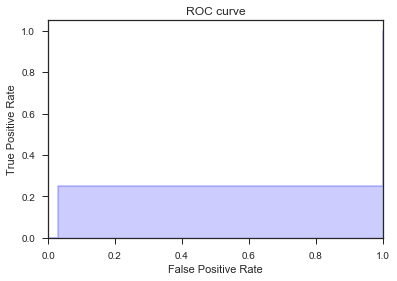

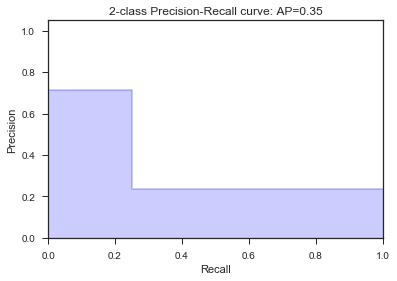

In [178]:
x, mod_results, mod_acc = svm_mod('Taiwan','SVM',tai_x_train, tai_x_test, tai_x_val, tai_y_train, tai_y_test, tai_y_val)
results = pd.concat([results, mod_results])
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)


In [179]:
# Evaluation of accuracy results thus far

# Overall Classification Accuracy
print('\n'*2+'Overall Classification Accuracy Results from First Round:')
display(acc_results)

# average precision, recall, and f1_score by technique
class1_res = (results.loc[(results['class'].astype('int') == 1)])
print('\n'*2+'All Class Accuracy Results from First Round:')
display(class1_res)

table1 = pd.pivot_table(class1_res, values=['precision','recall', 'f1_score'], index=['technique'],aggfunc=np.mean)
print()
print('\n'*2+'Table 1'+'\n'+'Average Scores by Technique Across 3 Datasets:')
display(table1)

table2 = pd.pivot_table(class1_res, values=['precision','recall', 'f1_score'], index=['dataset'],aggfunc=np.mean)
print('\n'*2+'Table 2'+'\n'+'Average Scores by Dataset Across 3 Techniques:')
display(table2)





Overall Classification Accuracy Results from First Round:


dataset  accuracy_score   technique
0    Germany            0.74    Logistic
1  Australia            0.88    Logistic
2     Taiwan            0.81    Logistic
3    Germany            0.68  Class Tree
4  Australia            0.90  Class Tree
5     Taiwan            0.82  Class Tree
6    Germany            0.72         SVM
7  Australia            0.85         SVM
8     Taiwan            0.80         SVM



All Class Accuracy Results from First Round:


class    dataset  f1_score  precision  recall support   technique
1      1    Germany      0.61       0.65    0.57      35    Logistic
1      1  Australia      0.87       0.89    0.85      40    Logistic
1      1     Taiwan      0.37       0.77    0.25     528    Logistic
1      1    Germany      0.33       0.62    0.23      35  Class Tree
1      1  Australia      0.90       0.92    0.88      40  Class Tree
1      1     Taiwan      0.48       0.70    0.37     528  Class Tree
1      1    Germany      0.53       0.64    0.46      35         SVM
1      1  Australia      0.84       0.91    0.78      40         SVM
1      1     Taiwan      0.37       0.71    0.25     528         SVM




Table 1
Average Scores by Technique Across 3 Datasets:


f1_score  precision  recall
technique                              
Class Tree      0.57       0.75    0.49
Logistic        0.62       0.77    0.56
SVM             0.58       0.75    0.50



Table 2
Average Scores by Dataset Across 3 Techniques:


f1_score  precision  recall
dataset                               
Australia      0.87       0.91    0.84
Germany        0.49       0.64    0.42
Taiwan         0.41       0.73    0.29

<a id='feature_engineering'></a>
## VI. Engineering New Features for a Second Round of Models

In [180]:
# Feature Engineering -- extracting information from payment timing in Taiwan dataset

# find locations of columns used in calculation
a = taiwan.columns.get_loc('PAY_0')
b = taiwan.columns.get_loc('PAY_6')
pay_code_features = list(taiwan.columns[a:b+1])

def count_late(row):
    num_late = 0
    for col in pay_code_features:
        if row[col] > 0:
            num_late += 1

    return num_late

def count_early(row):
    num_early = 0
    for col in pay_code_features:
        if row[col] < -1:
            num_early += 1

    return num_early

def on_time(row):
    num_ontime = 0
    for col in pay_code_features:
        if row[col] in (0,-1):
            num_ontime += 1

    return num_ontime

def max_late(row):
    maxlate = 0
    for col in pay_code_features:
        if row[col] > maxlate:
            maxlate = row[col]

    return maxlate

def months_late(row):
    monthslate = 0
    for col in pay_code_features:
        if row[col] > 0:
            monthslate += row[col]

    return monthslate

taiwan_s = taiwan.assign(lates=taiwan.apply(count_late, axis=1))
taiwan_s = taiwan_s.assign(earlies=taiwan_s.apply(count_early, axis=1))
taiwan_s = taiwan_s.assign(ontimes=taiwan_s.apply(on_time, axis=1))
taiwan_s = taiwan_s.assign(maxlate=taiwan_s.apply(max_late, axis=1))
taiwan_s = taiwan_s.assign(monthslate=taiwan_s.apply(months_late, axis=1))


In [181]:
# print some of the default records, with the original and calculated features
display(taiwan_s[list(taiwan_s.columns[6:12]) + list(taiwan_s.columns[12:])][taiwan_s['Default_Pmt'] == 1].head(5))
taiwan_s.info()

PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  \
0       2     -1     -1     -2     -2       3913       3102        689   
1       2      0      0      0      2       2682       1725       2682   
13      2      2      0      0      2      65802      67369      65701   
16      0      2      2      2      2      15376      18010      17428   
21     -1     -1     -1     -1     -1        316        316        316   

    BILL_AMT4  BILL_AMT5     ...      PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0           0          0     ...             0         0         0         0   
1        3272       3455     ...          1000      1000         0      2000   
13      66782      36137     ...          3000      3000      1500         0   
16      18338      17905     ...          1500         0      1650         0   
21          0        632     ...             0       632       316         0   

    Default_Pmt  lates  earlies  ontimes  maxlate  monthslate  
0             1      2        2        2        2           4  
1             1      2        0        4        2           4  
13            1      4        0        2        2           7  
16            1      4        0        2        2           8  
21            1      0        0        6        0           0  

[5 rows x 23 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 29 columns):
LIMIT_BAL      30000 non-null int64
SEX            30000 non-null object
EDUCATION      30000 non-null object
MARRIAGE       30000 non-null object
AGE            30000 non-null int64
PAY_0          30000 non-null int64
PAY_2          30000 non-null int64
PAY_3          30000 non-null int64
PAY_4          30000 non-null int64
PAY_5          30000 non-null int64
PAY_6          30000 non-null int64
BILL_AMT1      30000 non-null int64
BILL_AMT2      30000 non-null int64
BILL_AMT3      30000 non-null int64
BILL_AMT4      30000 non-null int64
BILL_AMT5      30000 non-null int64
BILL_AMT6      30000 non-null int64
PAY_AMT1       30000 non-null int64
PAY_AMT2       30000 non-null int64
PAY_AMT3       30000 non-null int64
PAY_AMT4       30000 non-null int64
PAY_AMT5       30000 non-null int64
PAY_AMT6       30000 non-null int64
Default_Pmt    30000 non-null int64
lates          30000 non

In [182]:
# Feature Engineering of Billing Amounts, Payment Amounts and Limit
# Preprocessing step

def dollar_features(df):

    # find locations of columns used in calculation
    a = df.columns.get_loc('BILL_AMT1')
    b = df.columns.get_loc('BILL_AMT6')
    c = df.columns.get_loc('PAY_AMT1')
    d = df.columns.get_loc('PAY_AMT6')

    bill_amt_features = list(df.columns[a:b+1]) # list of billed amount features
    pay_amt_features = list(df.columns[c:d+1]) # list of pay amount features

    # Create features: bill as pct of limit
    for col in bill_amt_features:
        df[col+'_LIMPCT'] = df[col]/df['LIMIT_BAL']

    # Create features: pmt amt as pct of bill
    for paycol in pay_amt_features:
        for billcol in bill_amt_features:
            if pay_amt_features.index(paycol) == bill_amt_features.index(billcol):
                    df[paycol+'_PCT_BILL'] = df[paycol]/df[billcol]   

    # Consider case of 'inf' where pmt is made despite zero balance
    # We will "reward" consumer with a 1
    for column in df:
        df[column].replace(np.inf, 1, inplace=True)

    # Consider case of 'NaN' which results from 0/0 -- no payment where none is due
    # Will fill with a the mean of the series to indicate no variation for use by models 1 
    for column in df:
        df[column].fillna(df[column].mean(), inplace=True)                     

    # Checking results
    #display(df.describe())

    # Create lists of new features for summary statistics generation
    a = df.columns.get_loc('BILL_AMT1_LIMPCT')
    b = df.columns.get_loc('BILL_AMT6_LIMPCT')
    c = df.columns.get_loc('PAY_AMT1_PCT_BILL')
    d = df.columns.get_loc('PAY_AMT6_PCT_BILL')

    bill_pct_lim_features = list(df.columns[a:b+1]) 
    pmt_pct_bill_features = list(df.columns[c:d+1]) 
    
    return df,  bill_amt_features, pay_amt_features, bill_pct_lim_features, pmt_pct_bill_features

taiwan_s, bill_amt_features, pay_amt_features, bill_pct_lim_features, pmt_pct_bill_features = dollar_features(taiwan_s)

In [183]:
# Functions to calculate averages, maximums, trends

# Find the maximum pct of limit
def max_pct_lim(row):
    maxpct = 0
    for col in bill_pct_lim_features:
        if row[col] > maxpct:
            maxpct = row[col]

    return maxpct

# Find the average pct of limit
def avg_pct_lim(row):
    sumpct = 0
    avgpct = 0
    n = 0
    for col in bill_pct_lim_features:
        sumpct = sumpct + row[col]
        n += 1
        avgpct = sumpct / n
        
    return avgpct

# Find the maximum pay as pct of bill
def max_pct_bill(row):
    maxpct = 0
    for col in pmt_pct_bill_features:
        if row[col] > maxpct:
            maxpct = row[col]

    return maxpct

# Find the average pay as pct of bill
def avg_pct_bill(row):
    sumpct = 0
    avgpct = 0
    n = 0
    for col in pmt_pct_bill_features:
        sumpct = sumpct + row[col]
        n += 1
        avgpct = sumpct / n

    return avgpct

# Find the trends over bill as pct of limit and pay as pct of bill

def trend(data, order=1):
    coeffs = np.polyfit(data.index.values, list(data), order)
    slope = coeffs[-2]

    return float(slope)

def trend_bill(row):
    datalist = []
    indexer = []
    i = 0
    for col in bill_pct_lim_features:
        datalist.append(row[col])
        i += 1
        indexer.append(i)
    df = pd.DataFrame({'indexer': indexer, 'datalist': datalist})
    x = trend(df['datalist'])

    return x

def trend_pay(row):
    datalist = []
    indexer = []
    i = 0
    for col in pmt_pct_bill_features:
        datalist.append(row[col])
        i += 1
        indexer.append(i)
    df = pd.DataFrame({'indexer': indexer, 'datalist': datalist})
    x = trend(df['datalist'])

    return x

In [184]:
# Execute new metric calculation

def metrics_calc(inp):
    outp = inp.assign(maxpctlim=inp.apply(max_pct_lim, axis=1))
    outp = outp.assign(avgpctlim=outp.apply(avg_pct_lim, axis=1))
    outp = outp.assign(maxpctbill=outp.apply(max_pct_bill, axis=1))
    outp = outp.assign(avgpctbill=outp.apply(avg_pct_bill, axis=1))
    outp = outp.assign(trendbill=outp.apply(trend_bill, axis=1))
    outp = outp.assign(trendpay=outp.apply(trend_pay, axis=1))

    return outp

taiwan_s = metrics_calc(taiwan_s)


In [185]:
# Inspect Output
display(taiwan_s.head(5)) # are all features filled in, and calculations look correct? Yes
display(taiwan_s.describe()) # are there any NaN or inf left? No.
display(taiwan_s.dtypes) # what are the data types? how much re-processing do I have to do?

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5    ...     PAY_AMT3_PCT_BILL  PAY_AMT4_PCT_BILL  PAY_AMT5_PCT_BILL  \
0     -2    ...                  0.00              -1.52              -0.79   
1      0    ...                  0.37               0.31               0.00   
2      0    ...                  0.07               0.07               0.07   
3      0    ...                  0.02               0.04               0.04   
4      0    ...                  0.28               0.43               0.04   

   PAY_AMT6_PCT_BILL  maxpctlim  avgpctlim  maxpctbill  avgpctbill  trendbill  \
0              -0.65       0.20       0.06        0.22       -0.46      -0.04   
1               0.61       0.03       0.02        0.61        0.31       0.00   
2               0.32       0.32       0.19        0.32        0.12      -0.02   
3               0.03       0.99       0.77        0.04        0.04      -0.09   
4               0.04       0.72       0.36        6.47        1.25       0.04   

   trendpay  
0     -0.22  
1      0.04  
2      0.03  
3     -0.00  
4     -0.58  

[5 rows x 47 columns]

LIMIT_BAL      SEX  EDUCATION  MARRIAGE      AGE    PAY_0    PAY_2  \
count   30000.00 30000.00   30000.00  30000.00 30000.00 30000.00 30000.00   
mean   167484.32     1.60       1.85      1.55    35.49    -0.02    -0.13   
std    129747.66     0.49       0.79      0.52     9.22     1.12     1.20   
min     10000.00     1.00       0.00      0.00    21.00    -2.00    -2.00   
25%     50000.00     1.00       1.00      1.00    28.00    -1.00    -1.00   
50%    140000.00     2.00       2.00      2.00    34.00     0.00     0.00   
75%    240000.00     2.00       2.00      2.00    41.00     0.00     0.00   
max   1000000.00     2.00       6.00      3.00    79.00     8.00     8.00   

         PAY_3    PAY_4    PAY_5    ...     PAY_AMT3_PCT_BILL  \
count 30000.00 30000.00 30000.00    ...              30000.00   
mean     -0.17    -0.22    -0.27    ...                 -6.69   
std       1.20     1.17     1.13    ...                602.02   
min      -2.00    -2.00    -2.00    ...             -82150.00   
25%      -1.00    -1.00    -1.00    ...                  0.02   
50%       0.00     0.00     0.00    ...                  0.04   
75%       0.00     0.00     0.00    ...                  0.19   
max       8.00     8.00     8.00    ...               6333.33   

       PAY_AMT4_PCT_BILL  PAY_AMT5_PCT_BILL  PAY_AMT6_PCT_BILL  maxpctlim  \
count           30000.00           30000.00           30000.00   30000.00   
mean               -1.52              -0.79              -0.65       0.49   
std               145.55              65.83              80.58       0.43   
min            -17266.67           -7483.95          -11349.57       0.00   
25%                 0.01               0.02               0.00       0.07   
50%                 0.04               0.04               0.04       0.43   
75%                 0.17               0.19               0.20       0.92   
max              8891.36            1738.42            2643.33      10.69   

       avgpctlim  maxpctbill  avgpctbill  trendbill  trendpay  
count   30000.00    30000.00    30000.00   30000.00  30000.00  
mean        0.37        7.07       -2.29      -0.02      0.47  
std         0.35      118.32      114.50       0.06     40.60  
min        -0.23        0.00   -13727.48      -1.17  -1636.26  
25%         0.03        0.07        0.04      -0.04     -0.03  
50%         0.28        0.22        0.06      -0.00     -0.00  
75%         0.69        2.00        0.61       0.01      0.03  
max         5.36    11453.67     3703.61       0.46   5062.98  

[8 rows x 47 columns]

LIMIT_BAL              int64
SEX                    int64
EDUCATION              int64
MARRIAGE               int64
AGE                    int64
PAY_0                  int64
PAY_2                  int64
PAY_3                  int64
PAY_4                  int64
PAY_5                  int64
PAY_6                  int64
BILL_AMT1              int64
BILL_AMT2              int64
BILL_AMT3              int64
BILL_AMT4              int64
BILL_AMT5              int64
BILL_AMT6              int64
PAY_AMT1               int64
PAY_AMT2               int64
PAY_AMT3               int64
PAY_AMT4               int64
PAY_AMT5               int64
PAY_AMT6               int64
Default_Pmt            int64
lates                  int64
earlies                int64
ontimes                int64
maxlate                int64
monthslate             int64
BILL_AMT1_LIMPCT     float64
BILL_AMT2_LIMPCT     float64
BILL_AMT3_LIMPCT     float64
BILL_AMT4_LIMPCT     float64
BILL_AMT5_LIMPCT     float64
BILL_AMT6_LIMP

In [186]:
# Reprocess Taiwan data with the new features

# Reclassify as object data types
objcol = ['SEX','EDUCATION','MARRIAGE']
objmaker(taiwan_s,objcol)
display(taiwan_s[['SEX','EDUCATION','MARRIAGE']].dtypes) 

# Rerun preprocessing routines
taiwan_pre = preproc('Taiwan',taiwan_s,'Default_Pmt')
#display(taiwan_pre.dtypes)

# Recreate train, test, and validation sets on Taiwan dataset
tai_x_train, tai_x_test, tai_x_val, tai_y_train, tai_y_test, tai_y_val = splitter(
    'Taiwan',taiwan_pre,'Default_Pmt',.1,.5)


SEX          object
EDUCATION    object
MARRIAGE     object
dtype: object


Dataset: Taiwan
Creating dummy variables ...
Input shape for categorical features: (30000, 3)
Output shape for categorical features: (30000, 54)


LIMIT_BAL      AGE    PAY_0    PAY_2    PAY_3    PAY_4    PAY_5  \
count   30000.00 30000.00 30000.00 30000.00 30000.00 30000.00 30000.00   
mean   167484.32    35.49    -0.02    -0.13    -0.17    -0.22    -0.27   
std    129747.66     9.22     1.12     1.20     1.20     1.17     1.13   
min     10000.00    21.00    -2.00    -2.00    -2.00    -2.00    -2.00   
25%     50000.00    28.00    -1.00    -1.00    -1.00    -1.00    -1.00   
50%    140000.00    34.00     0.00     0.00     0.00     0.00     0.00   
75%    240000.00    41.00     0.00     0.00     0.00     0.00     0.00   
max   1000000.00    79.00     8.00     8.00     8.00     8.00     8.00   

         PAY_6  BILL_AMT1  BILL_AMT2     ...        SEX_2  EDUCATION_1  \
count 30000.00   30000.00   30000.00     ...     30000.00     30000.00   
mean     -0.29   51223.33   49179.08     ...         0.60         0.35   
std       1.15   73635.86   71173.77     ...         0.49         0.48   
min      -2.00 -165580.00  -69777.00     ...         0.00         0.00   
25%      -1.00    3558.75    2984.75     ...         0.00         0.00   
50%       0.00   22381.50   21200.00     ...         1.00         0.00   
75%       0.00   67091.00   64006.25     ...         1.00         1.00   
max       8.00  964511.00  983931.00     ...         1.00         1.00   

       EDUCATION_2  EDUCATION_3  EDUCATION_4  EDUCATION_5  EDUCATION_6  \
count     30000.00     30000.00     30000.00     30000.00     30000.00   
mean          0.47         0.16         0.00         0.01         0.00   
std           0.50         0.37         0.06         0.10         0.04   
min           0.00         0.00         0.00         0.00         0.00   
25%           0.00         0.00         0.00         0.00         0.00   
50%           0.00         0.00         0.00         0.00         0.00   
75%           1.00         0.00         0.00         0.00         0.00   
max           1.00         1.00         1.00         1.00         1.00   

       MARRIAGE_1  MARRIAGE_2  MARRIAGE_3  
count    30000.00    30000.00    30000.00  
mean         0.46        0.53        0.01  
std          0.50        0.50        0.10  
min          0.00        0.00        0.00  
25%          0.00        0.00        0.00  
50%          0.00        1.00        0.00  
75%          1.00        1.00        0.00  
max          1.00        1.00        1.00  

[8 rows x 54 columns]


Dataset: Taiwan
Scaling numeric variables ...
Input shape for features: (30000, 43)
Output shape for numeric features: (30000, 54)


LIMIT_BAL      AGE    PAY_0    PAY_2    PAY_3    PAY_4    PAY_5  \
count   30000.00 30000.00 30000.00 30000.00 30000.00 30000.00 30000.00   
mean        0.00    -0.00    -0.00    -0.00    -0.00    -0.00    -0.00   
std         1.00     1.00     1.00     1.00     1.00     1.00     1.00   
min        -1.21    -1.57    -1.76    -1.56    -1.53    -1.52    -1.53   
25%        -0.91    -0.81    -0.87    -0.72    -0.70    -0.67    -0.65   
50%        -0.21    -0.16     0.01     0.11     0.14     0.19     0.23   
75%         0.56     0.60     0.01     0.11     0.14     0.19     0.23   
max         6.42     4.72     7.13     6.79     6.82     7.03     7.29   

         PAY_6  BILL_AMT1  BILL_AMT2     ...        SEX_2  EDUCATION_1  \
count 30000.00   30000.00   30000.00     ...     30000.00     30000.00   
mean     -0.00       0.00      -0.00     ...         0.60         0.35   
std       1.00       1.00       1.00     ...         0.49         0.48   
min      -1.49      -2.94      -1.67     ...         0.00         0.00   
25%      -0.62      -0.65      -0.65     ...         0.00         0.00   
50%       0.25      -0.39      -0.39     ...         1.00         0.00   
75%       0.25       0.22       0.21     ...         1.00         1.00   
max       7.21      12.40      13.13     ...         1.00         1.00   

       EDUCATION_2  EDUCATION_3  EDUCATION_4  EDUCATION_5  EDUCATION_6  \
count     30000.00     30000.00     30000.00     30000.00     30000.00   
mean          0.47         0.16         0.00         0.01         0.00   
std           0.50         0.37         0.06         0.10         0.04   
min           0.00         0.00         0.00         0.00         0.00   
25%           0.00         0.00         0.00         0.00         0.00   
50%           0.00         0.00         0.00         0.00         0.00   
75%           1.00         0.00         0.00         0.00         0.00   
max           1.00         1.00         1.00         1.00         1.00   

       MARRIAGE_1  MARRIAGE_2  MARRIAGE_3  
count    30000.00    30000.00    30000.00  
mean         0.46        0.53        0.01  
std          0.50        0.50        0.10  
min          0.00        0.00        0.00  
25%          0.00        0.00        0.00  
50%          0.00        1.00        0.00  
75%          1.00        1.00        0.00  
max          1.00        1.00        1.00  

[8 rows x 54 columns]

Dataset: Taiwan

Splitting into train, validate, and test sets . . . 

There are 27000 training observations.
There are 1500 validation observations.
There are 1500 test observations.

Shape of the label datasets: 
y_train: (27000,)
y_val: (1500,)
y_test: (1500,)



<a id='estimation2'></a>
## VII. Model Estimation - Round II - Taiwan Data

In [187]:
# Create empty dataframe to store model results
columns = ['class','dataset', 'f1_score', 'precision','recall','support','technique']
resultsv2 = pd.DataFrame(columns=columns)
resultsv2.drop(resultsv2.index, inplace=True)

Confusion Matrix: 


array([[1089,   53],
       [ 258,  100]])


Accuracy Score: 



0.79266666666666663


Classification Report: 
             precision    recall  f1-score   support

          0       0.81      0.95      0.88      1142
          1       0.65      0.28      0.39       358

avg / total       0.77      0.79      0.76      1500



'Average precision-recall score: 0.51'

Train error: 0.189555555556
Test error: 0.192666666667
Validation error: 0.207333333333


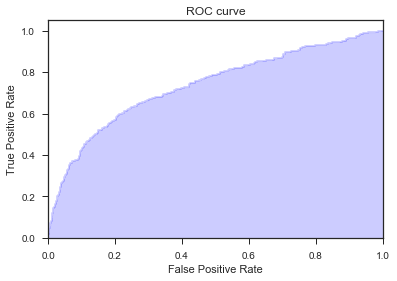

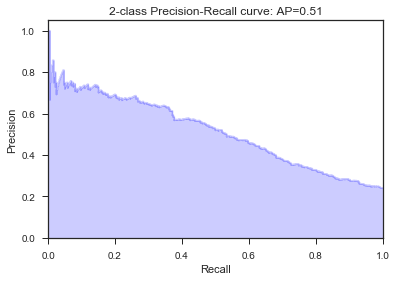

In [188]:
# ReRun the Logistic Regression model using the Taiwan data
x, mod_results, mod_acc = log_mod('Taiwan','Logistic 2',tai_x_train, tai_x_test, tai_x_val, tai_y_train, tai_y_test, tai_y_val)
resultsv2 = pd.concat([resultsv2, mod_results])
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)


Confusion Matrix: 


array([[1090,   52],
       [ 242,  116]])


Accuracy Score: 



0.80400000000000005


Classification Report: 
             precision    recall  f1-score   support

          0       0.82      0.95      0.88      1142
          1       0.69      0.32      0.44       358

avg / total       0.79      0.80      0.78      1500



'Average precision-recall score: 0.51'

Train error: 0.176
Test error: 0.176
Validation error: 0.196


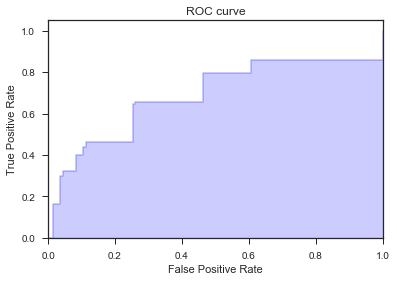

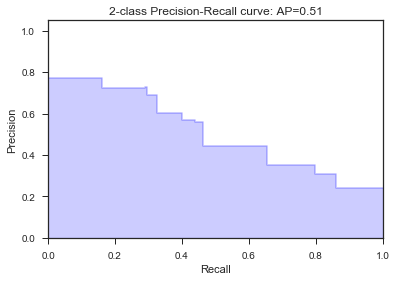

In [189]:
# ReRun the classification model using the Taiwan data
x, mod_results, mod_acc = tree_mod('Taiwan','Class Tree 2',tai_x_train, tai_x_test, tai_x_val, tai_y_train, tai_y_test, tai_y_val)
resultsv2 = pd.concat([resultsv2, mod_results])
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)


{'loss': 'hinge', 'penalty': 'l2', 'shuffle': True}
GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=8675309,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['hinge'], 'penalty': ['l2'], 'shuffle': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
Confusion Matrix: 


array([[1128,   14],
       [ 310,   48]])


Accuracy Score: 



0.78400000000000003


Classification Report: 
             precision    recall  f1-score   support

          0       0.78      0.99      0.87      1142
          1       0.77      0.13      0.23       358

avg / total       0.78      0.78      0.72      1500



'Average precision-recall score: 0.31'

Train error: 0.203481481481
Test error: 0.205333333333
Validation error: 0.216


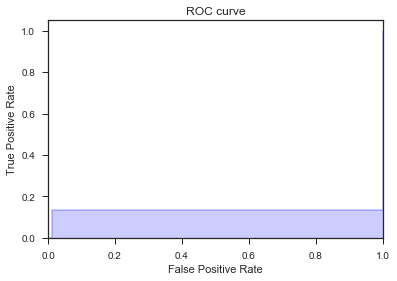

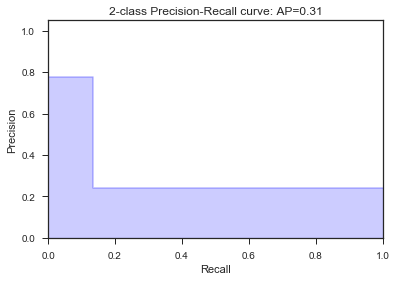

In [190]:
# ReRun the SVM model using the Taiwan data
# Please note this SVM setup does not appear to allow for export of predicted probabilities, thus precision/recall 
# curves are built off of the predicted class only

x, mod_results, mod_acc = svm_mod('Taiwan','SVM 2',tai_x_train, tai_x_test, tai_x_val, tai_y_train, tai_y_test, tai_y_val)
resultsv2 = pd.concat([resultsv2, mod_results])
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)


In [191]:
# Evaluation of accuracy results thus far

# Overall Classification Accuracy
print('\n'*2+'Overall Classification Accuracy Results from First & Second Rounds:')
display(acc_results.loc[(acc_results["dataset"] == 'Taiwan')])

print('\n'+'All Results from 1st and 2nd rounds: Taiwan'+'\n')
display(results.loc[(results["dataset"] == 'Taiwan')])
display(resultsv2)

# average precision, recall, and f1_score by technique

print('\n'*2,'Class = 1 Results from the first round of models: Taiwan dataset'+'\n')
tw_res = (results.loc[(results["dataset"] == 'Taiwan') & (results['class'].astype('int') == 1)])
temp = pd.pivot_table(tw_res, values=['precision','recall', 'f1_score'], index=['technique'],aggfunc=np.mean)
display(temp)

print('\n')

print('Class = 1 Results from the 2nd round of models: Taiwan dataset'+'\n')
tw_res = (resultsv2.loc[(resultsv2["dataset"] == 'Taiwan') & (resultsv2['class'].astype('int') == 1)])
temp = pd.pivot_table(tw_res, values=['precision','recall', 'f1_score'], index=['technique'],aggfunc=np.mean)
display(temp)





Overall Classification Accuracy Results from First & Second Rounds:


dataset  accuracy_score     technique
2   Taiwan            0.81      Logistic
5   Taiwan            0.82    Class Tree
8   Taiwan            0.80           SVM
9   Taiwan            0.79    Logistic 2
10  Taiwan            0.80  Class Tree 2
11  Taiwan            0.78         SVM 2


All Results from 1st and 2nd rounds: Taiwan



class dataset  f1_score  precision  recall support   technique
0      0  Taiwan      0.89       0.81    0.98    1722    Logistic
1      1  Taiwan      0.37       0.77    0.25     528    Logistic
0      0  Taiwan      0.89       0.83    0.95    1722  Class Tree
1      1  Taiwan      0.48       0.70    0.37     528  Class Tree
0      0  Taiwan      0.88       0.81    0.97    1722         SVM
1      1  Taiwan      0.37       0.71    0.25     528         SVM

class dataset  f1_score  precision  recall support     technique
0      0  Taiwan      0.88       0.81    0.95    1142    Logistic 2
1      1  Taiwan      0.39       0.65    0.28     358    Logistic 2
0      0  Taiwan      0.88       0.82    0.95    1142  Class Tree 2
1      1  Taiwan      0.44       0.69    0.32     358  Class Tree 2
0      0  Taiwan      0.87       0.78    0.99    1142         SVM 2
1      1  Taiwan      0.23       0.77    0.13     358         SVM 2



 Class = 1 Results from the first round of models: Taiwan dataset



f1_score  precision  recall
technique                              
Class Tree      0.48       0.70    0.37
Logistic        0.37       0.77    0.25
SVM             0.37       0.71    0.25



Class = 1 Results from the 2nd round of models: Taiwan dataset



f1_score  precision  recall
technique                                
Class Tree 2      0.44       0.69    0.32
Logistic 2        0.39       0.65    0.28
SVM 2             0.23       0.77    0.13

<a id='mlp-taiwan'></a>
## VIII. MLP on Taiwan Dataset

In [192]:
# Get the shape of the input we'll need for the MLP
tai_x_train.shape

(27000, 53)

In [193]:
# define model using Keras
from keras.utils import np_utils
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization 
from keras.models import Sequential

model = Sequential()

model.add(Dense(100, input_shape=(53,), kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(100, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(50, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(50, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(25, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               5400      
_________________________________________________________________
batch_normalization_6 (Batch (None, 100)               400       
_________________________________________________________________
activation_6 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)               400       
_________________________________________________________________
activation_7 (Activation)    (None, 100)               0         
__________

In [194]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])


In [195]:
from keras.callbacks import ModelCheckpoint, History
    
# train the model
checkpointer = ModelCheckpoint(filepath='MLP.weights.best.hdf5', verbose=1, 
    save_best_only=True)

hist = model.fit(tai_x_train, tai_y_train, batch_size=16, epochs=5,
    validation_data=(tai_x_test, tai_y_test), callbacks=[checkpointer], verbose=2, shuffle=True)


Train on 27000 samples, validate on 1500 samples
Epoch 1/5

Epoch 00001: val_loss improved from inf to 0.45047, saving model to MLP.weights.best.hdf5
 - 24s - loss: 0.4735 - acc: 0.7988 - val_loss: 0.4505 - val_acc: 0.8100
Epoch 2/5

Epoch 00002: val_loss improved from 0.45047 to 0.44429, saving model to MLP.weights.best.hdf5
 - 12s - loss: 0.4602 - acc: 0.8009 - val_loss: 0.4443 - val_acc: 0.8187
Epoch 3/5

Epoch 00003: val_loss did not improve
 - 12s - loss: 0.4555 - acc: 0.8022 - val_loss: 0.4459 - val_acc: 0.8193
Epoch 4/5

Epoch 00004: val_loss improved from 0.44429 to 0.44161, saving model to MLP.weights.best.hdf5
 - 11s - loss: 0.4539 - acc: 0.8063 - val_loss: 0.4416 - val_acc: 0.8213
Epoch 5/5

Epoch 00005: val_loss did not improve
 - 12s - loss: 0.4540 - acc: 0.8057 - val_loss: 0.4418 - val_acc: 0.8133


In [196]:
# load the weights that yielded the best validation accuracy
model.load_weights('MLP.weights.best.hdf5')

1500/1500 [==============================] - 0s 287us/step
Confusion Matrix: 


array([[1088,   54],
       [ 244,  114]])


Accuracy Score: 



0.80133333333333334


Classification Report: 
             precision    recall  f1-score   support

          0       0.82      0.95      0.88      1142
          1       0.68      0.32      0.43       358

avg / total       0.78      0.80      0.77      1500



'Average precision-recall score: 0.54'

Train error: 0.135987767046
Test error: 0.137951471094
Validation error: 0.148559197424


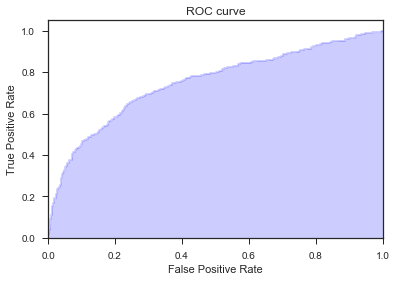

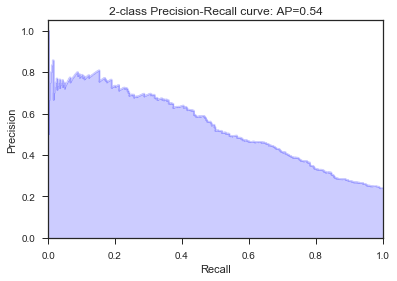

In [197]:
# Produce diagnostic reports 
y_pred_prob = model.predict_proba(tai_x_val, batch_size=32, verbose=1)
y_pred_class = model.predict_classes(tai_x_val)

report, accscore = class_diag(tai_y_val, y_pred_class, y_pred_prob)
mod_results = report_results_to_df('Taiwan','Neural Network',report)
resultsv2 = pd.concat([resultsv2, mod_results])
mod_acc = ['Taiwan','Neural Network', accscore]
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)

# Train, test, validation error
train_error, test_error, valid_error = model_error(tai_x_train,tai_y_train,tai_x_test,tai_y_test,tai_x_val,tai_y_val,model)
print('Train error: '+str(train_error))
print('Test error: '+str(test_error))
print('Validation error: '+str(valid_error))        


In [198]:
# display Taiwan results from all estimations

# Overall Classification Accuracy
print('\n'*2+'Overall Classification Accuracy Results from All Rounds:')
display(acc_results.loc[(acc_results["dataset"] == 'Taiwan')])

print('\n'+'All Results from All rounds: Taiwan'+'\n')
display(results.loc[(results["dataset"] == 'Taiwan')])
display(resultsv2)

# average precision, recall, and f1_score by technique

print('\n'*2,'Class = 1 Results from the first round of models: Taiwan dataset'+'\n')
tw_res = (results.loc[(results["dataset"] == 'Taiwan') & (results['class'].astype('int') == 1)])
temp = pd.pivot_table(tw_res, values=['precision','recall', 'f1_score'], index=['technique'],aggfunc=np.mean)
display(temp)

print('\n')

print('Class = 1 Results from the 2nd round of models: Taiwan dataset'+'\n')
tw_res = (resultsv2.loc[(resultsv2["dataset"] == 'Taiwan') & (resultsv2['class'].astype('int') == 1)])
temp = pd.pivot_table(tw_res, values=['precision','recall', 'f1_score'], index=['technique'],aggfunc=np.mean)
display(temp)




Overall Classification Accuracy Results from All Rounds:


dataset  accuracy_score       technique
2   Taiwan            0.81        Logistic
5   Taiwan            0.82      Class Tree
8   Taiwan            0.80             SVM
9   Taiwan            0.79      Logistic 2
10  Taiwan            0.80    Class Tree 2
11  Taiwan            0.78           SVM 2
12  Taiwan            0.80  Neural Network


All Results from All rounds: Taiwan



class dataset  f1_score  precision  recall support   technique
0      0  Taiwan      0.89       0.81    0.98    1722    Logistic
1      1  Taiwan      0.37       0.77    0.25     528    Logistic
0      0  Taiwan      0.89       0.83    0.95    1722  Class Tree
1      1  Taiwan      0.48       0.70    0.37     528  Class Tree
0      0  Taiwan      0.88       0.81    0.97    1722         SVM
1      1  Taiwan      0.37       0.71    0.25     528         SVM

class dataset  f1_score  precision  recall support       technique
0      0  Taiwan      0.88       0.81    0.95    1142      Logistic 2
1      1  Taiwan      0.39       0.65    0.28     358      Logistic 2
0      0  Taiwan      0.88       0.82    0.95    1142    Class Tree 2
1      1  Taiwan      0.44       0.69    0.32     358    Class Tree 2
0      0  Taiwan      0.87       0.78    0.99    1142           SVM 2
1      1  Taiwan      0.23       0.77    0.13     358           SVM 2
0      0  Taiwan      0.88       0.82    0.95    1142  Neural Network
1      1  Taiwan      0.43       0.68    0.32     358  Neural Network



 Class = 1 Results from the first round of models: Taiwan dataset



f1_score  precision  recall
technique                              
Class Tree      0.48       0.70    0.37
Logistic        0.37       0.77    0.25
SVM             0.37       0.71    0.25



Class = 1 Results from the 2nd round of models: Taiwan dataset



f1_score  precision  recall
technique                                  
Class Tree 2        0.44       0.69    0.32
Logistic 2          0.39       0.65    0.28
Neural Network      0.43       0.68    0.32
SVM 2               0.23       0.77    0.13

<a id='rnn-taiwan'></a>
## IX. RNN - Sequence Model

In [199]:
# Prepare data for sequence model

# Extract lists of time series features
paycodelist = ['PAY_0', 'PAY_2' , 'PAY_3', 'PAY_4', 'PAY_5','PAY_6']
billlist = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
paylist = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
billpctlist = ['BILL_AMT1_LIMPCT','BILL_AMT2_LIMPCT','BILL_AMT3_LIMPCT','BILL_AMT4_LIMPCT','BILL_AMT5_LIMPCT','BILL_AMT6_LIMPCT']
paypctlist = ['PAY_AMT1_PCT_BILL','PAY_AMT2_PCT_BILL','PAY_AMT3_PCT_BILL','PAY_AMT4_PCT_BILL','PAY_AMT5_PCT_BILL','PAY_AMT6_PCT_BILL']

# Subset our train, test, and validation sets to contain only those features
tai_x_lstm_train = pd.concat([tai_x_train[paycodelist], tai_x_train[billlist], tai_x_train[paylist],
    tai_x_train[billpctlist],tai_x_train[paypctlist]], axis = 1)

print('Train Shape before reshape: '+str(tai_x_lstm_train.shape))

tai_x_lstm_test = pd.concat([tai_x_test[paycodelist], tai_x_test[billlist], tai_x_test[paylist],
    tai_x_test[billpctlist],tai_x_test[paypctlist]], axis = 1)

print('Test Shape before reshape: '+str(tai_x_lstm_test.shape))


tai_x_lstm_val = pd.concat([tai_x_val[paycodelist], tai_x_val[billlist], tai_x_val[paylist],
    tai_x_val[billpctlist],tai_x_val[paypctlist]], axis = 1)

print('Val Shape before reshape: '+str(tai_x_lstm_val.shape))

print('\n')

# The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].
tai_lstm_train_reshape = np.reshape(np.array(tai_x_lstm_train), (tai_x_lstm_train.shape[0],6,-1), order='F')
print('Train Shape after reshape: '+str(tai_lstm_train_reshape.shape))

tai_lstm_test_reshape = np.reshape(np.array(tai_x_lstm_test), (tai_x_lstm_test.shape[0],6,-1), order='F')
print('Test Shape after reshape: '+str(tai_lstm_test_reshape.shape))

tai_lstm_val_reshape = np.reshape(np.array(tai_x_lstm_val), (tai_x_lstm_val.shape[0],6,-1), order='F')
print('Val Shape after reshape: '+str(tai_lstm_val_reshape.shape))

# Data check
#display(np.array(tai_x_lstm_train[0:2]))
#display(tai_lstm_train_reshape[0:2])


Train Shape before reshape: (27000, 30)
Test Shape before reshape: (1500, 30)
Val Shape before reshape: (1500, 30)


Train Shape after reshape: (27000, 6, 5)
Test Shape after reshape: (1500, 6, 5)
Val Shape after reshape: (1500, 6, 5)


In [200]:
# Specify the RNN model

from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(100, input_shape=(6,5),return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 6, 100)            42400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 6, 100)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
_________________________________________________________________
None


In [201]:
# Train the model
from keras.callbacks import ModelCheckpoint, History
    
checkpointer = ModelCheckpoint(filepath='RNN.weights.best.hdf5', verbose=1, 
    save_best_only=True)

hist = model.fit(tai_lstm_train_reshape, tai_y_train, batch_size=16, epochs=5,
    validation_data=(tai_lstm_test_reshape, tai_y_test), callbacks=[checkpointer], verbose=2, shuffle=True)


Train on 27000 samples, validate on 1500 samples
Epoch 1/5

Epoch 00001: val_loss improved from inf to 0.45044, saving model to RNN.weights.best.hdf5
 - 50s - loss: 0.4562 - acc: 0.8084 - val_loss: 0.4504 - val_acc: 0.8127
Epoch 2/5

Epoch 00002: val_loss improved from 0.45044 to 0.44771, saving model to RNN.weights.best.hdf5
 - 61s - loss: 0.4416 - acc: 0.8122 - val_loss: 0.4477 - val_acc: 0.8127
Epoch 3/5

Epoch 00003: val_loss did not improve
 - 56s - loss: 0.4381 - acc: 0.8139 - val_loss: 0.4644 - val_acc: 0.8047
Epoch 4/5

Epoch 00004: val_loss improved from 0.44771 to 0.43865, saving model to RNN.weights.best.hdf5
 - 56s - loss: 0.4356 - acc: 0.8143 - val_loss: 0.4387 - val_acc: 0.8180
Epoch 5/5

Epoch 00005: val_loss did not improve
 - 58s - loss: 0.4334 - acc: 0.8189 - val_loss: 0.4409 - val_acc: 0.8247


1500/1500 [==============================] - 1s 762us/step
Confusion Matrix: 


array([[1066,   76],
       [ 222,  136]])


Accuracy Score: 



0.80133333333333334


Classification Report: 
             precision    recall  f1-score   support

          0       0.83      0.93      0.88      1142
          1       0.64      0.38      0.48       358

avg / total       0.78      0.80      0.78      1500



'Average precision-recall score: 0.57'

Train error: 0.1349828296
Test error: 0.137033925514
Validation error: 0.146486614496


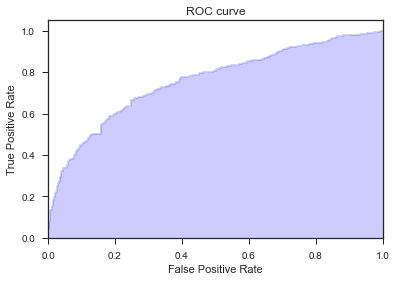

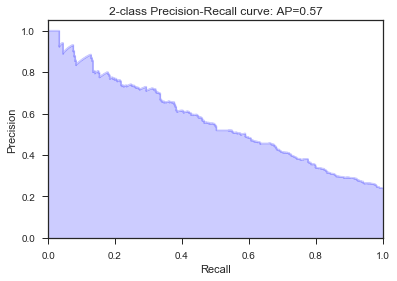

In [202]:
# Assessing Accuracy of RNN

# load the weights that yielded the best validation accuracy
model.load_weights('RNN.weights.best.hdf5')

# Produce diagnostic reports 
y_pred_prob = model.predict_proba(tai_lstm_val_reshape, batch_size=32, verbose=1)
y_pred_class = model.predict_classes(tai_lstm_val_reshape)

report, accscore = class_diag(tai_y_val, y_pred_class, y_pred_prob)
mod_results = report_results_to_df('Taiwan','RNN - LSTM',report)
resultsv2 = pd.concat([resultsv2, mod_results])
mod_acc = ['Taiwan','RNN - LSTM', accscore]
temp1 = pd.Series([mod_acc[0],mod_acc[2],mod_acc[1]], index = ['dataset','accuracy_score','technique'])
acc_results = acc_results.append(temp1, ignore_index=True)

# Train, test, validation error
train_error, test_error, valid_error = model_error(tai_lstm_train_reshape,tai_y_train,tai_lstm_test_reshape,tai_y_test,tai_lstm_val_reshape,tai_y_val,model)
print('Train error: '+str(train_error))
print('Test error: '+str(test_error))
print('Validation error: '+str(valid_error))


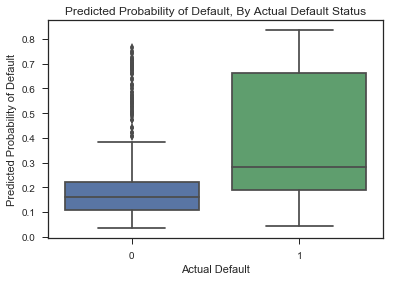

In [203]:
# Probability score analysis
t1 = np.ndarray.flatten(y_pred_class)
t2 = np.ndarray.flatten(y_pred_prob)
dft = pd.DataFrame({'y_val':tai_y_val, 'y_pred_class':t1, 'y_pred_prob':t2})

sns.boxplot(x='y_val', y='y_pred_prob', data=dft)
plt.title("Predicted Probability of Default, By Actual Default Status")
plt.xlabel("Actual Default")
plt.ylabel("Predicted Probability of Default")

fig = plt.gcf()

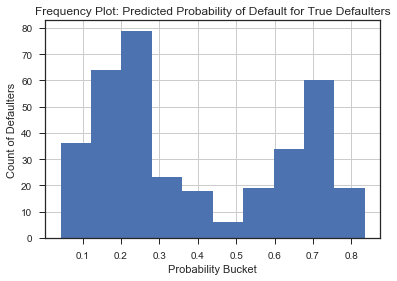

In [204]:
x = dft.loc[(dft['y_val'] == 1)]['y_pred_prob']
x.hist()
plt.title("Frequency Plot: Predicted Probability of Default for True Defaulters")
plt.xlabel("Probability Bucket")
plt.ylabel("Count of Defaulters")

fig = plt.gcf()

In [205]:
# Accuracy: display Taiwan results from all estimations

# Overall Classification Accuracy
print('\n'*2+'Overall Classification Accuracy Results from All Rounds:')
display(acc_results.loc[(acc_results["dataset"] == 'Taiwan')])

print('\n'+'All Results from All rounds: Taiwan'+'\n')
display(results.loc[(results["dataset"] == 'Taiwan')])
display(resultsv2)

# average precision, recall, and f1_score by technique

print('\n'*2,'Class = 1 Results from the first round of models: Taiwan dataset'+'\n')
tw_res = (results.loc[(results["dataset"] == 'Taiwan') & (results['class'].astype('int') == 1)])
temp = pd.pivot_table(tw_res, values=['precision','recall', 'f1_score'], index=['technique'],aggfunc=np.mean)
display(temp)

print('\n')

print('Class = 1 Results from the 2nd round of models: Taiwan dataset'+'\n')
tw_res = (resultsv2.loc[(resultsv2["dataset"] == 'Taiwan') & (resultsv2['class'].astype('int') == 1)])
temp = pd.pivot_table(tw_res, values=['precision','recall', 'f1_score'], index=['technique'],aggfunc=np.mean)
display(temp)



Overall Classification Accuracy Results from All Rounds:


dataset  accuracy_score       technique
2   Taiwan            0.81        Logistic
5   Taiwan            0.82      Class Tree
8   Taiwan            0.80             SVM
9   Taiwan            0.79      Logistic 2
10  Taiwan            0.80    Class Tree 2
11  Taiwan            0.78           SVM 2
12  Taiwan            0.80  Neural Network
13  Taiwan            0.80      RNN - LSTM


All Results from All rounds: Taiwan



class dataset  f1_score  precision  recall support   technique
0      0  Taiwan      0.89       0.81    0.98    1722    Logistic
1      1  Taiwan      0.37       0.77    0.25     528    Logistic
0      0  Taiwan      0.89       0.83    0.95    1722  Class Tree
1      1  Taiwan      0.48       0.70    0.37     528  Class Tree
0      0  Taiwan      0.88       0.81    0.97    1722         SVM
1      1  Taiwan      0.37       0.71    0.25     528         SVM

class dataset  f1_score  precision  recall support       technique
0      0  Taiwan      0.88       0.81    0.95    1142      Logistic 2
1      1  Taiwan      0.39       0.65    0.28     358      Logistic 2
0      0  Taiwan      0.88       0.82    0.95    1142    Class Tree 2
1      1  Taiwan      0.44       0.69    0.32     358    Class Tree 2
0      0  Taiwan      0.87       0.78    0.99    1142           SVM 2
1      1  Taiwan      0.23       0.77    0.13     358           SVM 2
0      0  Taiwan      0.88       0.82    0.95    1142  Neural Network
1      1  Taiwan      0.43       0.68    0.32     358  Neural Network
0      0  Taiwan      0.88       0.83    0.93    1142      RNN - LSTM
1      1  Taiwan      0.48       0.64    0.38     358      RNN - LSTM



 Class = 1 Results from the first round of models: Taiwan dataset



f1_score  precision  recall
technique                              
Class Tree      0.48       0.70    0.37
Logistic        0.37       0.77    0.25
SVM             0.37       0.71    0.25



Class = 1 Results from the 2nd round of models: Taiwan dataset



f1_score  precision  recall
technique                                  
Class Tree 2        0.44       0.69    0.32
Logistic 2          0.39       0.65    0.28
Neural Network      0.43       0.68    0.32
RNN - LSTM          0.48       0.64    0.38
SVM 2               0.23       0.77    0.13

<a id='conclusions'></a>
## X. Final Accuracy Statistics

In [206]:
print('\n'*2+'Model Classification Accuracy for the Taiwan dataset:'+'\n')
acc_results_lim = acc_results.loc[(acc_results["dataset"] == 'Taiwan')]
display(acc_results_lim.sort_values(by=['accuracy_score'],ascending=False))



Model Classification Accuracy for the Taiwan dataset:



dataset  accuracy_score       technique
5   Taiwan            0.82      Class Tree
2   Taiwan            0.81        Logistic
10  Taiwan            0.80    Class Tree 2
12  Taiwan            0.80  Neural Network
13  Taiwan            0.80      RNN - LSTM
8   Taiwan            0.80             SVM
9   Taiwan            0.79      Logistic 2
11  Taiwan            0.78           SVM 2

In [207]:
# Display summary of results
print('First round of estimations on all datasets:'+'\n')
display(results.loc[results['class'].astype('int') == 1])

print('\n'*2+'All estimation results for the Taiwan dataset:'+'\n')
set1 = results.loc[(results['dataset'] == 'Taiwan') & (results['class'].astype('int') == 1)]
set2 = resultsv2.loc[resultsv2['class'].astype('int') == 1]
final_result = pd.concat([set1, set2], axis=0)
display(final_result.sort_values(by=['recall'],ascending=False))

First round of estimations on all datasets:



class    dataset  f1_score  precision  recall support   technique
1      1    Germany      0.61       0.65    0.57      35    Logistic
1      1  Australia      0.87       0.89    0.85      40    Logistic
1      1     Taiwan      0.37       0.77    0.25     528    Logistic
1      1    Germany      0.33       0.62    0.23      35  Class Tree
1      1  Australia      0.90       0.92    0.88      40  Class Tree
1      1     Taiwan      0.48       0.70    0.37     528  Class Tree
1      1    Germany      0.53       0.64    0.46      35         SVM
1      1  Australia      0.84       0.91    0.78      40         SVM
1      1     Taiwan      0.37       0.71    0.25     528         SVM



All estimation results for the Taiwan dataset:



class dataset  f1_score  precision  recall support       technique
1      1  Taiwan      0.48       0.64    0.38     358      RNN - LSTM
1      1  Taiwan      0.48       0.70    0.37     528      Class Tree
1      1  Taiwan      0.44       0.69    0.32     358    Class Tree 2
1      1  Taiwan      0.43       0.68    0.32     358  Neural Network
1      1  Taiwan      0.39       0.65    0.28     358      Logistic 2
1      1  Taiwan      0.37       0.77    0.25     528        Logistic
1      1  Taiwan      0.37       0.71    0.25     528             SVM
1      1  Taiwan      0.23       0.77    0.13     358           SVM 2